## Prerequisites

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.stats import ttest_ind

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler


import originalcsv file

In [2]:
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv', encoding='utf-8')

First we print a preview of our dataframe to get a broad overview of the data

In [3]:
print(df.head())


   Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \


# 2.1 Dataset Overview

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

#### Dataset Overview Analysis

The dataset consists of 1433 responses from a mental health survey in tech companies 
with 63 columns (variables) covering different aspects:

Data Structure:
- Number of observations: 1433 entries
- Number of variables: 63 columns

Data Types:
1. Numerical Variables (7 columns):
   - Integer (int64): 4 columns
     Examples: age, self-employment status, treatment history
   - Float (float64): 3 columns
     Examples: tech company indicator, tech role indicator
   
2. Categorical Variables (56 columns):
   - Object type variables covering:
     - Employee benefits and resources
     - Workplace attitudes towards mental health
     - Personal mental health history
     - Demographics
     - Employment characteristics

Missing Values:
Some key variables show missing data patterns:
- Complete responses (1433 non-null) for demographic variables like age and gender
- Partial responses (1146 non-null) for current employer-related questions
- Limited responses (263-287 non-null) for specific mental health treatment questions

The high dimensionality and mix of data types suggests the need for:
1. Careful handling of missing values
2. Appropriate encoding of categorical variables
3. Dimensionality reduction for meaningful analysis


I want to start to explore the data. Therfore some standard visualizations should help to get an overview of distributions and correlations.

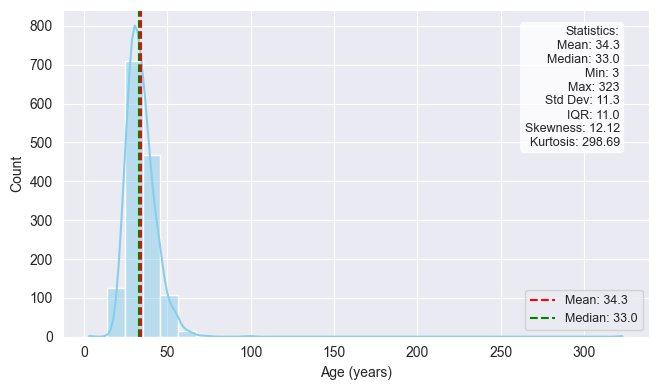

In [5]:
# Rename age column for easier handling
df = df.rename(columns={'What is your age?': 'age'})

# Calculate age statistics
age_mean = df['age'].mean()
age_median = df['age'].median()
age_std = df['age'].std()
age_skew = df['age'].skew()
age_kurtosis = df['age'].kurtosis()
age_iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
age_min = df['age'].min()
age_max = df['age'].max()

# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))  # Width matches A4 margins, height adjusted for proportion

# Set font to match document
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Create the main distribution plot
sns.histplot(data=df, x='age', bins=30, kde=True, color='skyblue')

# Add a vertical line for mean and median
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean: {age_mean:.1f}')
plt.axvline(age_median, color='green', linestyle='--', label=f'Median: {age_median:.1f}')

# Customize the plot
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Add statistical annotations in a text box
stats_text = (f'Statistics:\n'
            f'Mean: {age_mean:.1f}\n'
            f'Median: {age_median:.1f}\n'
            f'Min: {age_min}\n'
            f'Max: {age_max}\n'
            f'Std Dev: {age_std:.1f}\n'
            f'IQR: {age_iqr:.1f}\n'
            f'Skewness: {age_skew:.2f}\n'
            f'Kurtosis: {age_kurtosis:.2f}')

# Place text box in upper right corner
plt.text(0.95, 0.95, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=9)  # Slightly smaller font for stats

# Add legend with smaller font
plt.legend(fontsize=9)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save with exact dimensions and high DPI for clarity
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

The age distribution of survey respondents shows:
- Mean age of 34.3 years with median of 33.0 years, indicating a slightly right-skewed distribution
- Range from 3 to 323 years reveals clear data quality issues that need to be addressed:
 * The minimum age of 3 years is invalid for a workforce survey
 * The maximum age of 323 years is impossible and likely a data entry error
- Standard deviation of 11.3 years shows moderate spread when excluding outliers
- IQR (Interquartile Range) of 11.0 years represents the range between the 25th and 75th percentiles,
 indicating that the middle 50% of employees are within an 11-year age span
- Strong positive skewness (12.12) indicates a long right tail, partially due to invalid outliers
- Very high kurtosis (298.69) reflects the extreme outliers in the data

Data Quality Implications:
1. Data cleaning is required to handle invalid age entries
2. Age validation rules should be implemented for future surveys
3. Analysis should potentially focus on the core age range excluding outliers
4. Statistics like median and IQR are more reliable than mean/std given the outliers

Despite data quality issues, the visualization shows that the majority of the workforce 
is concentrated in the early-to-mid 30s range, which should be the primary focus for 
mental health support program design.

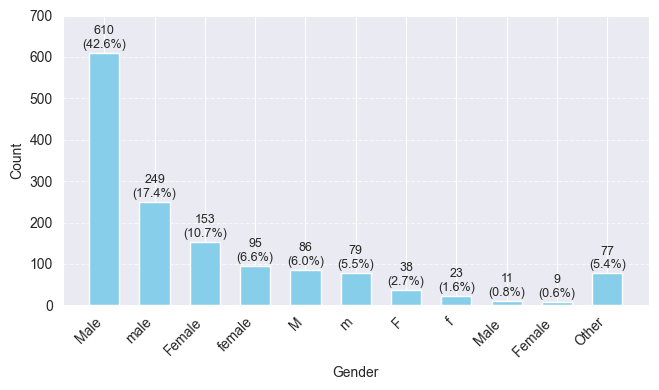

In [6]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match document
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate statistics and group smaller categories
gender_counts = df['What is your gender?'].value_counts()
top_10 = gender_counts.head(10)
other_sum = gender_counts[10:].sum()

# Create new series with Other at the end
final_counts = pd.concat([top_10, pd.Series({'Other': other_sum})])

total_responses = len(df)

# Create bar plot
bars = plt.bar(range(len(final_counts)), 
               final_counts.values, 
               color='skyblue', 
               width=0.6)

# Add value labels on bars
for i, v in enumerate(final_counts.values):
    percentage = (v/total_responses) * 100
    plt.text(i, v + 5,
             f'{v:,}\n({percentage:.1f}%)', 
             ha='center', 
             va='bottom',
             fontsize=9) 

# Customize the plot
plt.xlabel('Gender', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Set x-axis labels
plt.xticks(range(len(final_counts)), final_counts.index, rotation=45, ha='right')

# Set y-axis limits
plt.ylim(0, 700)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save with exact dimensions and high DPI for clarity
plt.savefig('gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Primary Distribution Patterns:
- Male-identifying responses dominate at about 72% of total responses, with "Male" (42.6%) and "male" (17.4%) being the most common variations
- Female-identifying responses comprise 23% of responses, primarily split between "Female" (10.7%) and "female" (6.6%)
- Non-binary and other gender identifications represent approximately 5% of responses
- Case sensitivity creates significant variation, with "M"/"m" accounting for 11.5% and "F"/"f" for 4.3% of responses

Data Quality Assessment:
- 70 unique variations in gender responses highlight inconsistent data collection
- Eight main variations account for 93.1% of all responses
- The remaining 62 variations each represent 0.8% or less of responses
- Responses include various formats:
  * Standard gender identifiers in different cases
  * Detailed gender identity descriptions
  * Informal or colloquial expressions
  * Some non-serious or protest responses

Statistical Implications:
1. Primary gender categories (Male/Female) show clear dominance but require standardization
2. Significant case sensitivity issues affect data consistency
3. Small but important representation of non-binary and other gender identities (approximately 5%)
4. Need for balance between standardization and respect for gender identity expression

The data suggests a strong male representation typical of the tech industry while highlighting the need for improved data collection methods that maintain inclusivity while ensuring analytical consistency.

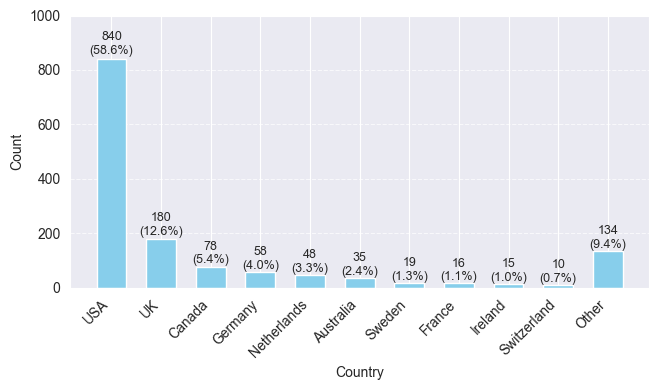

In [7]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match document
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate statistics and clean country names
country_counts = df['What country do you live in?'].replace({
    'United States of America': 'USA',
    'United Kingdom': 'UK'
}).value_counts()

# Get top 10 and sum others
top_10 = country_counts.head(10)
other_sum = country_counts[10:].sum()

# Create new series with Other at the end
final_counts = pd.concat([top_10, pd.Series({'Other': other_sum})])

total_responses = len(df)

# Create bar plot
bars = plt.bar(range(len(final_counts)), 
               final_counts.values, 
               color='skyblue', 
               width=0.6)

# Add value labels on bars
for i, v in enumerate(final_counts.values):
    percentage = (v/total_responses) * 100
    plt.text(i, v + (v * 0.01),
             f'{v:,}\n({percentage:.1f}%)', 
             ha='center', 
             va='bottom',
             fontsize=9)

# Customize the plot
plt.xlabel('Country', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.ylim(0, 1000)

# Set x-axis labels
plt.xticks(range(len(final_counts)), final_counts.index, rotation=45, ha='right')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save with high resolution
plt.savefig('country_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Primary Distribution Patterns:
- United States dominates with 840 respondents, representing 58.6% of the total sample
- European countries collectively form the second-largest group, led by the United Kingdom with 180 respondents (12.6%)
- North American representation is strengthened by Canada's 78 respondents (5.4%)
- Continental European presence is notable but fragmented, with Germany (4.0%), Netherlands (3.3%), and several countries below 2%
- Asia-Pacific region shows limited representation through Australia (2.4%) and scattered responses across other countries

Regional Concentration Analysis:
- English-speaking countries account for approximately 76.6% of all responses
- Western European nations comprise roughly 15% of the dataset
- Emerging tech hubs in Asia, Eastern Europe, and South America each represent less than 1% of responses
- Notable tech-focused regions like Israel and Singapore show minimal representation
- Developing nations' tech sectors are largely underrepresented in the survey

Statistical Implications:
1. Strong US-centric dataset provides robust sample for North American tech industry analysis
2. Secondary UK market offers meaningful comparative potential
3. Limited representation from other regions affects global generalizability
4. Statistically significant analysis possible only for top 3-5 countries
5. Need for careful interpretation of findings from countries with fewer than 20 respondents

The data reveals a clear Anglo-American focus, suggesting findings will be most applicable to English-speaking technology markets, particularly the United States.

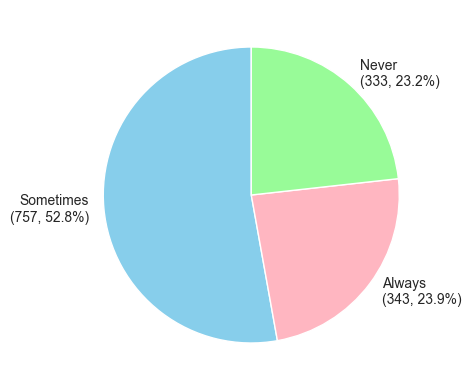

In [8]:
# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))

# Set font to match document requirements
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate remote work distribution
remote_counts = df['Do you work remotely?'].value_counts()
total_responses = len(df)

# Create pie chart using skyblue and complementary colors
plt.pie(remote_counts.values, 
        labels=[f'{label}\n({count:,}, {(count/total_responses)*100:.1f}%)' 
                for label, count in zip(remote_counts.index, remote_counts.values)],
        colors=['skyblue', '#FFB6C1', '#98FB98'],  # skyblue, lightpink, palegreen
        autopct='',
        startangle=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high resolution
plt.savefig('remote_work_distribution.png', 
            dpi=300, 
            bbox_inches='tight')

plt.show()

Primary Distribution Patterns:
- Hybrid work represents the majority with 757 respondents (52.8%) working remotely sometimes
- Full remote and no remote work show nearly equal distribution (23.9% and 23.2% respectively)
- The vast majority (76.7%) have some form of remote work arrangement, combining hybrid and full remote workers

Pattern Analysis:
- Clear dominance of flexible work arrangements reflects tech industry's adoption of modern work practices
- Even split between traditional office work and full remote indicates industry polarization
- High response rate in this category suggests reliable data quality

Statistical Implications:
1. Large hybrid work sample enables robust analysis of flexible work impacts on mental health
2. Balanced distribution between extreme cases (full remote vs. no remote) facilitates comparative studies
3. Sufficient sample sizes across all categories support meaningful statistical analysis

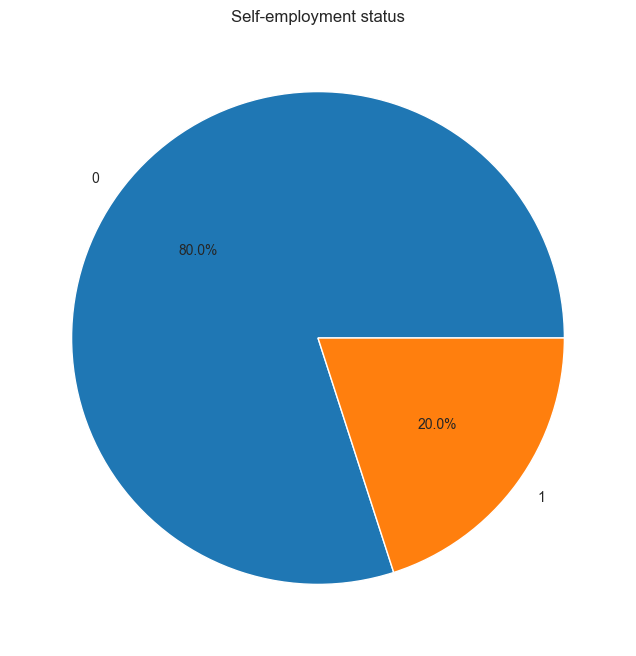

In [9]:
# Self-employment status
selfemp_counts = df['Are you self-employed?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(selfemp_counts.values, labels=selfemp_counts.index, autopct='%1.1f%%')
plt.title('Self-employment status')
plt.show()

Primary Distribution Patterns:
- Traditional employment strongly dominates with 1,146 respondents (80%) working as company employees
- Self-employed individuals represent a significant minority with 287 respondents (20%)
- Nearly complete response rate in this category indicates high data reliability

Pattern Analysis:
- The pronounced majority of company employees suggests prevalence of structured work environments
- The substantial self-employed segment indicates meaningful representation of independent tech workers
- Distribution aligns with typical tech industry employment patterns

Statistical Implications:
1. Large company employee sample provides robust foundation for analyzing corporate mental health practices
2. Self-employed segment size enables valid comparative analysis between employment types
3. Clear binary distribution supports straightforward statistical analysis
4. Strong response completeness indicates reliable data quality for employment status analysis

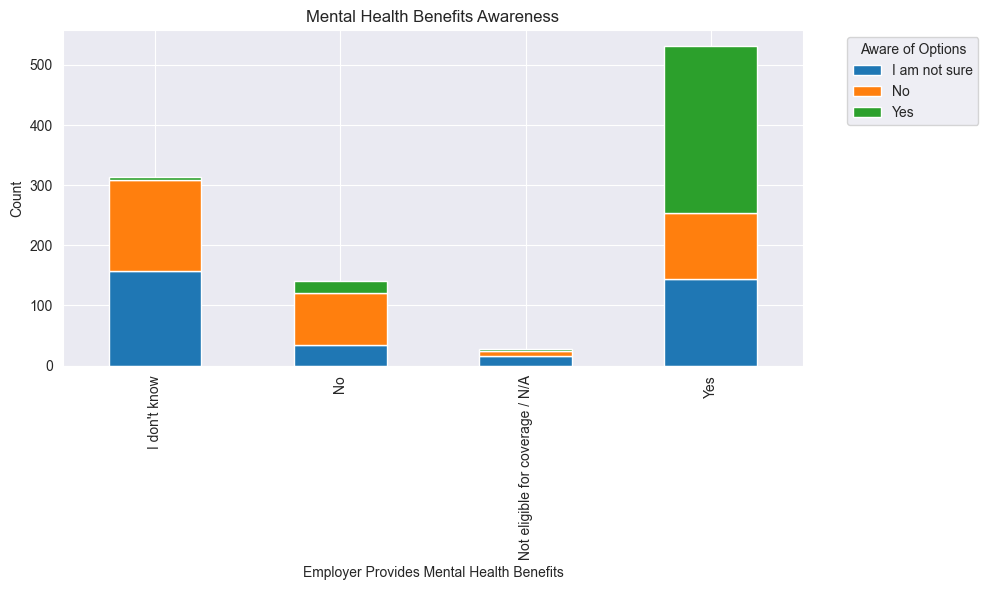

In [10]:
# Mental health benefits awareness
benefits_aware = pd.crosstab(df['Does your employer provide mental health benefits as part of healthcare coverage?'], 
                             df['Do you know the options for mental health care available under your employer-provided coverage?'])
benefits_aware.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Mental Health Benefits Awareness')
plt.xlabel('Employer Provides Mental Health Benefits')
plt.ylabel('Count')
plt.legend(title='Aware of Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Primary Distribution Patterns:
- A significant proportion of employers provide mental health benefits
- Notable portion of employers either don't provide benefits or have unclear benefit policies
- Employee awareness shows substantial variation regardless of benefit availability
- Small fraction of workforce reports ineligibility for coverage

Pattern Analysis:
- High provision of benefits indicates growing recognition of mental health importance
- Widespread uncertainty suggests systemic communication challenges
- Mixed awareness levels persist even in companies with established benefits
- Distribution reveals significant gaps between benefit provision and utilization

Statistical Implications:
1. Large number of benefit-providing employers enables robust analysis of implementation effectiveness
2. Substantial "unsure" responses indicate need for improved communication strategies
3. Clear disparity between benefit availability and awareness supports focus on communication analysis
4. Strong variation in benefit knowledge suggests opportunity for standardization

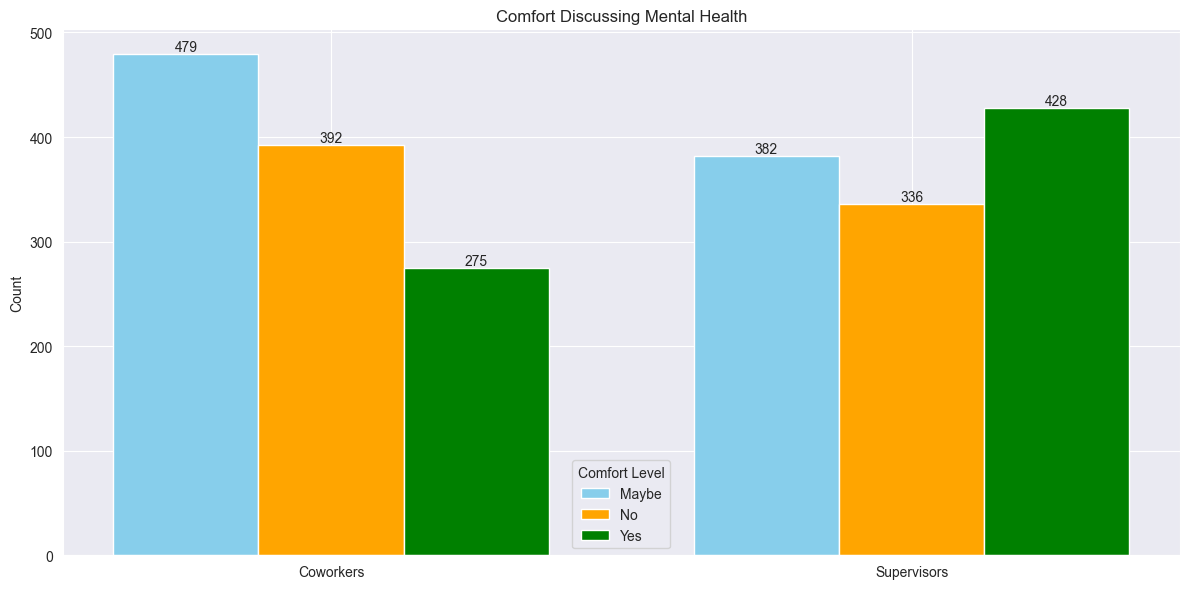

In [11]:
# Assuming df is your DataFrame
# Comfort discussing mental health
comfort_data = df[['Would you feel comfortable discussing a mental health disorder with your coworkers?',
                   'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?']]
comfort_data = comfort_data.melt(var_name='Discuss With', value_name='Comfort Level')
comfort_data['Discuss With'] = comfort_data['Discuss With'].map({
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'Coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'Supervisors'
})

# Count the data
count_data = comfort_data.groupby(['Discuss With', 'Comfort Level']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()

# Define bar width and positions
bar_width = 0.25
r1 = np.arange(len(count_data.index))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
bars1 = ax.bar(r1, count_data['Maybe'], bar_width, label='Maybe', color='skyblue')
bars2 = ax.bar(r2, count_data['No'], bar_width, label='No', color='orange')
bars3 = ax.bar(r3, count_data['Yes'], bar_width, label='Yes', color='green')

# Add labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Customize the plot
plt.title('Comfort Discussing Mental Health')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks([r + bar_width for r in range(len(count_data.index))], count_data.index)
plt.legend(title='Comfort Level')

plt.tight_layout()
plt.show()

Primary Distribution Patterns:
- Higher comfort level discussing mental health with supervisors (428 respondents) compared to coworkers (275)
- "Maybe" responses dominate both categories (479 for coworkers, 382 for supervisors)
- Greater discomfort in peer discussions (392) versus supervisor discussions (336)
- Combined uncertainty and discomfort exceeds comfort levels across all categories

Pattern Analysis:
- Clear preference for hierarchical communication channels
- Significant hesitancy in peer-level mental health discussions
- Context-dependent comfort levels suggest situational influences
- Systematic uncertainty indicates lack of clear communication guidelines

Statistical Implications:
1. Strong contrast between supervisor and peer comfort levels enables focused intervention strategies
2. High uncertainty rates across categories supports need for structural changes
3. Clear hierarchical preference pattern suggests targeted approach opportunities
4. Balanced distribution in supervisor responses indicates potential best practices

In [12]:
# Calculate the number and percentage of missing values
missing_values = df.isnull().sum()
missing_percentages = 100 * df.isnull().sum() / len(df)

# Combine into a table
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage Missing'])

# Sort by the number of missing values in descending order
missing_table = missing_table.sort_values('Missing Values', ascending=False)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display the table
print(missing_table)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

                                                    Missing Values  \
If you have revealed a mental health issue to a...            1289   
If yes, what percentage of your work time (time...            1229   
Is your primary role within your company relate...            1170   
Do you have medical coverage (private insurance...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have revealed a mental health issue to a...            1146   
Do you know local or online resources to seek h...            1146   
Do you believe your productivity is ever affect...            1146   
If maybe, what condition(s) do you believe you ...            1111   
If yes, what condition(s) have you been diagnos...             865   
Have your observations of how another individua...             776   
If so, what condition(s) were you diagnosed with?              722   
What US state or ter

There are a few columns that we will need to drop because too many values are missing. When the data is cleaned the issue of missing values needs to be addressed.

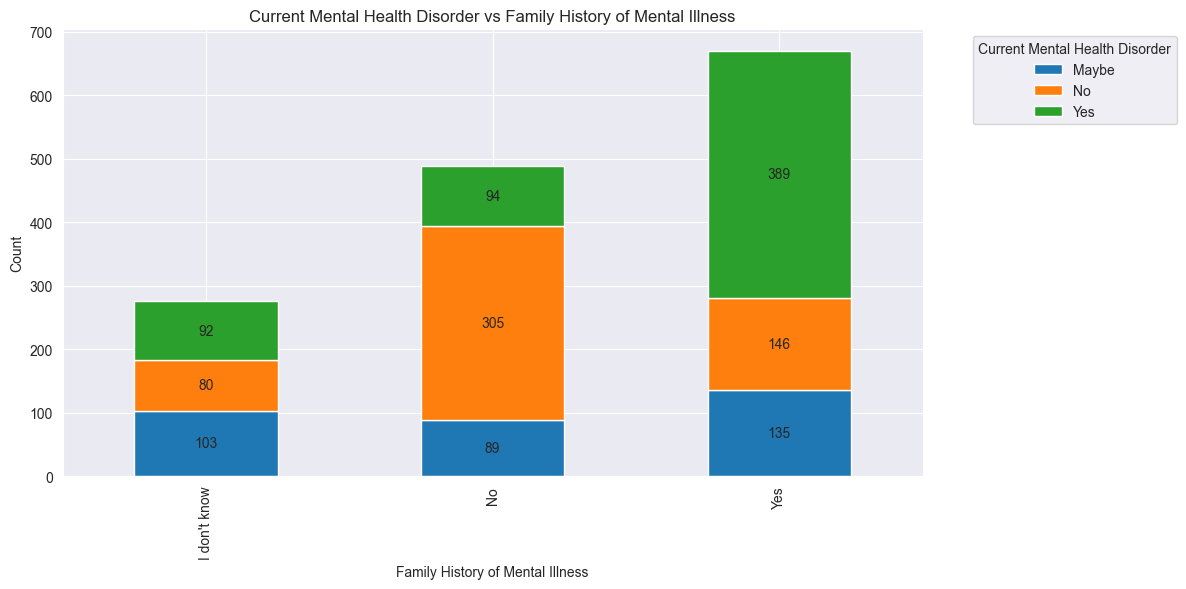

In [13]:
# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(df['Do you have a family history of mental illness?'], 
                        df['Do you currently have a mental health disorder?'])

# Create a stacked bar chart
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Current Mental Health Disorder vs Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.legend(title='Current Mental Health Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.show()

Primary Distribution Patterns:
- Strong correlation between family history and current mental health disorders (58% reporting both)
- Majority without family history shows no current disorders (62.5%)
- Significant uncertainty group (275 respondents) with balanced disorder distribution
- Notable presence of disorders (19%) even without family history

Pattern Analysis:
- Family history demonstrates strong but non-deterministic influence
- Multi-factorial nature of mental health disorders evident in distribution
- Uncertainty levels suggest gaps in family health knowledge
- Complex interplay between genetic and environmental factors apparent

Statistical Implications:
1. Strong correlation enables targeted support strategies for at-risk groups
2. Significant presence of disorders without family history supports comprehensive approach
3. Even distribution in uncertainty group indicates need for broader support systems
4. Clear patterns enable risk-factor based intervention development

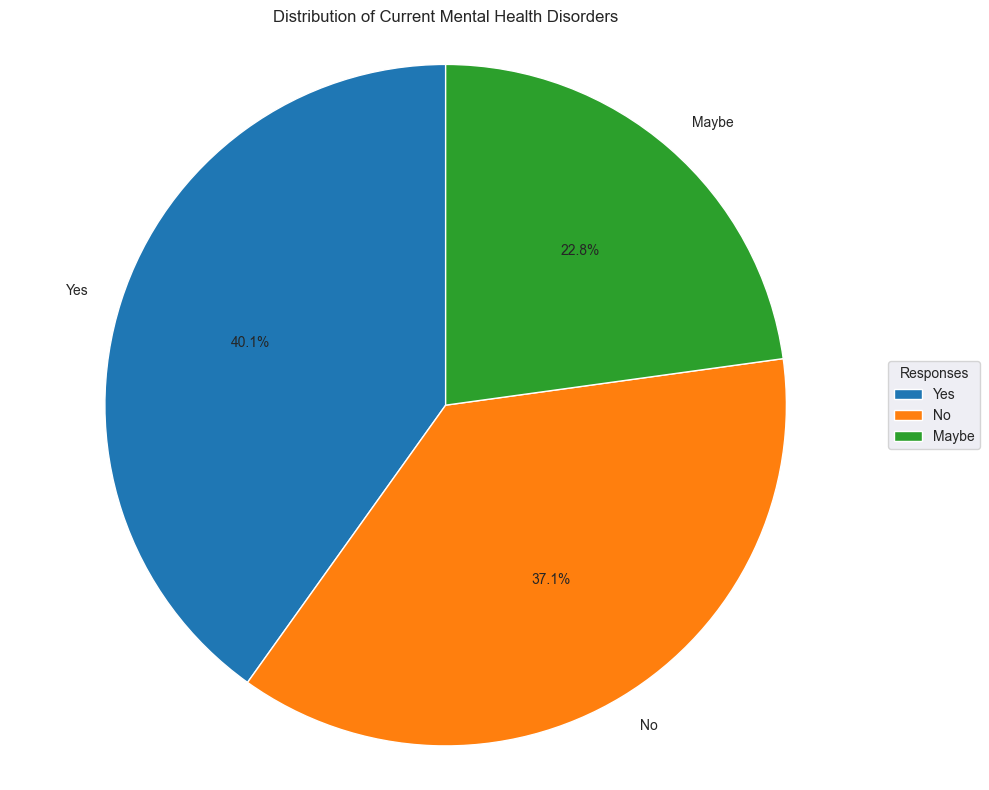

Do you currently have a mental health disorder?
Yes      575
No       531
Maybe    327
Name: count, dtype: int64


In [14]:
# Count the values in the column
value_counts = df['Do you currently have a mental health disorder?'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Current Mental Health Disorders')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(title="Responses", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print the exact counts
print(value_counts)

Primary Distribution Patterns:
- High prevalence of mental health disorders (40.1%, 575 respondents)
- Substantial portion without disorders (37.1%, 531 respondents)
- Significant uncertainty group (22.8%, 327 respondents)
- Combined affected and uncertain population forms majority (62.9%)

Pattern Analysis:
- Nearly balanced distribution between presence and absence of disorders
- Substantial uncertainty suggests potential underreporting
- High prevalence indicates industry-wide mental health challenges
- Open reporting suggests reduced but present stigma

Statistical Implications:
1. Large affected population enables robust analysis of support needs
2. Significant uncertainty group indicates diagnostic access gaps
3. Near-equal distribution supports comparative analysis
4. Strong prevalence data justifies resource allocation

## Feature Engineering - Data Preprocessing
We need to clean some columns before we continue. This includes renaming all columns for easier handling, such that we dont need to use the complete question string further on. Also we will standardize age column, mental health condition columns and convert all categorical columns to binary numerical columns.

In [15]:
# Rename all columns so they are handled more easily
# Define a dictionary to map old column names to new ones
column_map = {
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'emp_mh_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_mh_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'emp_discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'mh_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequences_mental_discuss',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequences_physical_discuss',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'comfortable_discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'comfortable_discuss_supervisors',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'emp_mh_seriously',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'observed_neg_consequences',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?': 'mh_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_online_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'neg_impact_reveal_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'neg_impact_reveal_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'mh_affects_productivity',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'productivity_affected_percent',
    'Do you have previous employers?': 'previous_emp',
    'Have your previous employers provided mental health benefits?': 'previous_emp_mh_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'aware_prev_mh_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_employers_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_mh_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity_protected',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequences_discuss',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequences_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_comfortable_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_comfortable_discuss_supervisors',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_emp_mh_seriously',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_observed_neg_consequences',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'mention_discuss_physical_interview',
    'Why or why not?': 'mention_discuss_physical_interview_reason',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'mention_discuss_mh_interview',
    'Why or why not?.1': 'mention_discuss_mh_interview_reason',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'mh_hurt_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworkers_view_negatively',
    'How willing would you be to share with friends and family that you have a mental illness?': 'willing_share_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'experienced_unsupportive_response',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'others_experience_affect_you',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'current_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'diagnosed_conditions',
    'If maybe, what condition(s) do you believe you have?': 'believed_conditions',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'professionally_diagnosed',
    'If so, what condition(s) were you diagnosed with?': 'professional_diagnoses',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you live in?': 'country',
    'What US state or territory do you live in?': 'state',
    'What country do you work in?': 'work_country',
    'What US state or territory do you work in?': 'work_state',
    'Which of the following best describes your work position?': 'position',
    'Do you work remotely?': 'remote_work'
}

# Rename the columns
df.rename(columns=column_map, inplace=True)

In [16]:
# Clean up the gender column
male_values = [
   'male', 'Male ', 'M', 'm', 'man', 'Cis male',
   'Male.', 'Male (cis)', 'Man', 'Sex is male',
   'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
   'mail', 'M|', 'male ', 'Cis Male', 'Male (trans, FtM)',
   'cisdude', 'cis man', 'MALE'
]

female_values = [
   'female', 'I identify as female.', 'female ',
   'Female assigned at birth ', 'F', 'Woman', 'fm', 'f',
   'Cis female', 'Transitioned, M2F', 'Female or Multi-Gender Femme',
   'Female ', 'woman', 'female/woman', 'Cisgender Female', 
   'mtf', 'fem', 'Female (props for making this a freeform field, though)',
   ' Female', 'Cis-woman', 'AFAB', 'Transgender woman',
   'Cis female '
]

other_values = [
   'Bigender', 'non-binary,', 'Genderfluid (born female)',
   'Other/Transfeminine', 'Androgynous', 'male 9:1 female, roughly',
   'nb masculine', 'genderqueer', 'Human', 'Genderfluid',
   'Enby', 'genderqueer woman', 'Queer', 'Agender', 'Fluid',
   'Genderflux demi-girl', 'female-bodied; no feelings about gender',
   'non-binary', 'Male/genderqueer', 'Nonbinary', 'Other', 'none of your business',
   'Unicorn', 'human', 'Genderqueer'
]

# Print total number of responses before preprocessing
print("Total responses before preprocessing:", len(df))

df['gender'] = df['gender'].replace(male_values, 'Male')
df['gender'] = df['gender'].replace(female_values, 'Female')
df['gender'] = df['gender'].replace(other_values, 'Others')

# Replace missing values with the mode Male
df['gender'] = df['gender'].replace(np.nan, 'Male')

# I later decided to drop "Other" gender
df = df[df['gender']!= 'Others']

# Print gender distribution statistics
print("\nGender Distribution after preprocessing:")
gender_counts = df['gender'].value_counts()
gender_percentages = df['gender'].value_counts(normalize=True) * 100

for gender in gender_counts.index:
   print(f"{gender}: {gender_counts[gender]} ({gender_percentages[gender]:.1f}%)")

# Print number of originally non-standardized entries
print(f"\nOriginal variations in gender responses:")
print(f"Male variations: {len(male_values)}")
print(f"Female variations: {len(female_values)}")
print(f"Other variations: {len(other_values)}")

# Print total after preprocessing
print("\nTotal responses after preprocessing:", len(df))

Total responses before preprocessing: 1433

Gender Distribution after preprocessing:
Male: 1061 (75.6%)
Female: 343 (24.4%)

Original variations in gender responses:
Male variations: 22
Female variations: 23
Other variations: 25

Total responses after preprocessing: 1404


In [17]:
# In this part we exclude some data from the dataframe that we dont want to use in our analysis
print(f"Original number of records: {len(df)}")

# Drop all rows where self_employed is 1, because from HR perspective only "normal" employees are relevant and afterward drop the column
df = df[df['self_employed'] == 0]
df=df.drop(columns=['self_employed'])
df = df.reset_index(drop=True)

print(f"Records after removing self-employed: {len(df)}")

# Drop all rows that are not USA and afterward drop column
df = df[df['work_country'] == 'United States of America']
df=df.drop(columns=['work_country'])
df = df.reset_index(drop=True)

print(f"Final records after USA filter: {len(df)}")

Original number of records: 1404
Records after removing self-employed: 1121
Final records after USA filter: 704


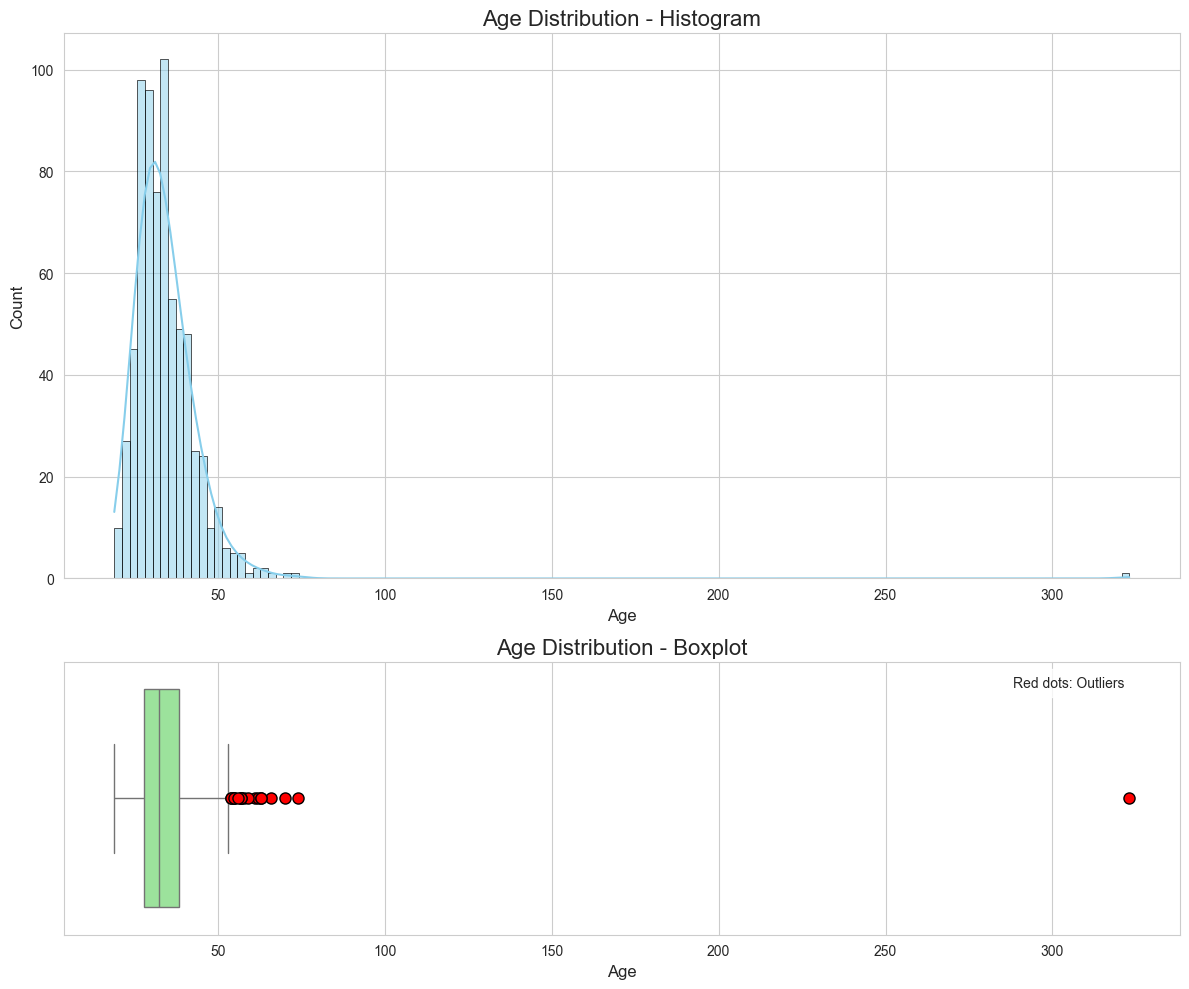

In [18]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Histogram plot
sns.histplot(data=df, x='age', kde=True, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Age Distribution - Histogram', fontsize=16)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Boxplot with marked outliers
sns.boxplot(data=df, x='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Age Distribution - Boxplot', fontsize=16)
ax2.set_xlabel('Age', fontsize=12)

# Add a text annotation explaining the outliers
ax2.text(0.95, 0.95, 'Red dots: Outliers', transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [19]:
# Find relevant outliers to replace them
# Get the top 5 max values
top_10 = df['age'].nlargest(10)

# Get the bottom 5 min values
bottom_10 = df['age'].nsmallest(10)

print("Top 10 maximum ages:")
print(top_10)

print("\nBottom 10 minimum ages:")
print(bottom_10)

Top 10 maximum ages:
292    323
532     74
602     70
358     66
377     63
603     63
305     62
253     61
362     59
330     58
Name: age, dtype: int64

Bottom 10 minimum ages:
290    19
151    20
386    20
620    20
89     21
304    21
333    21
638    21
639    21
649    21
Name: age, dtype: int64


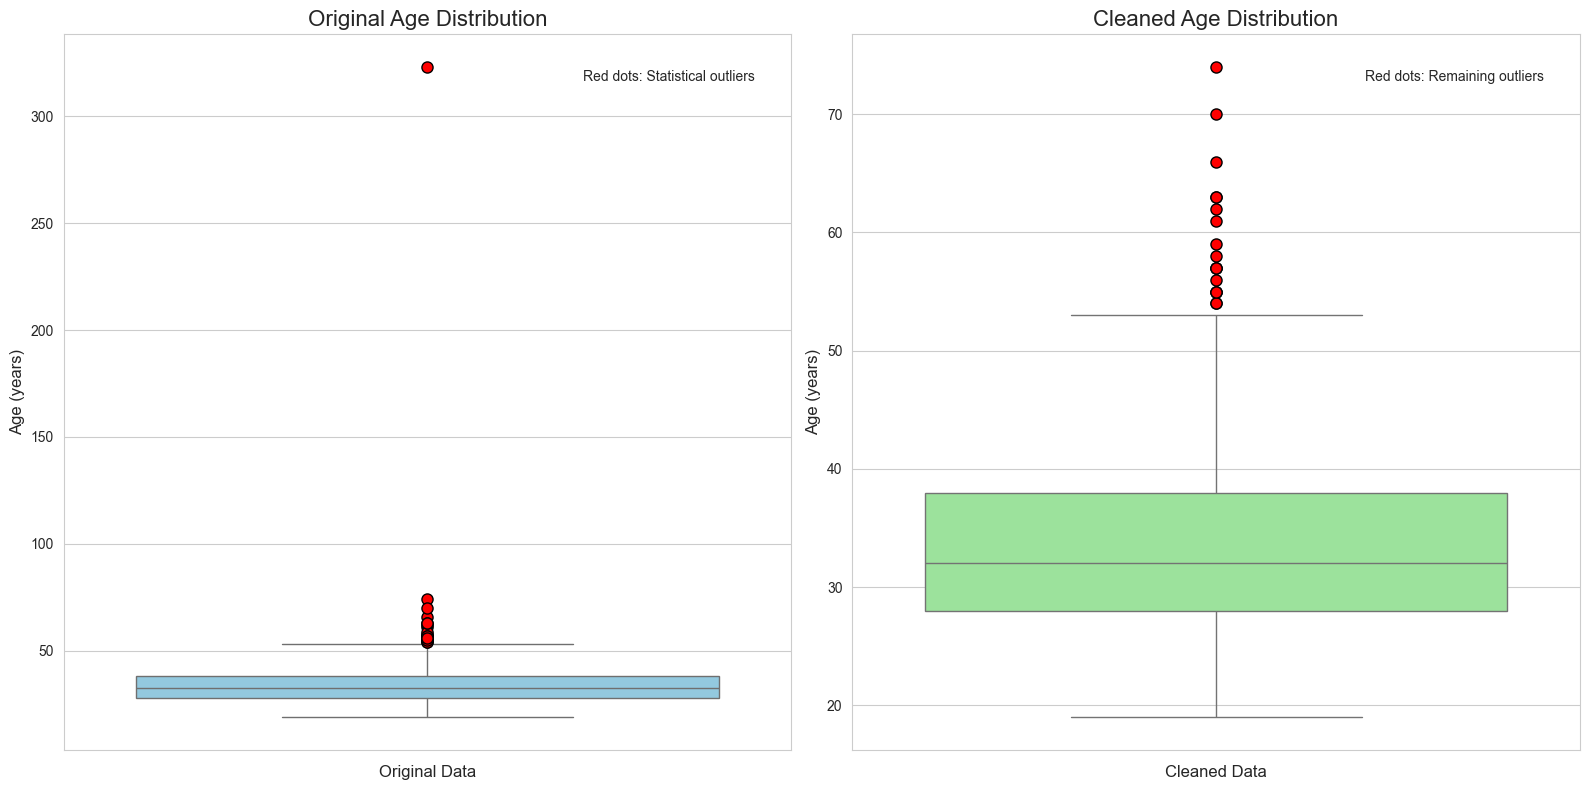


Descriptive Statistics - Original Age Distribution:
count    704.000000
mean      34.365057
std       13.546043
min       19.000000
25%       28.000000
50%       32.500000
75%       38.250000
max      323.000000
Name: age, dtype: float64

Descriptive Statistics - Cleaned Age Distribution:
count    704.000000
mean      33.951705
std        8.051431
min       19.000000
25%       28.000000
50%       32.000000
75%       38.000000
max       74.000000
Name: age, dtype: float64


In [20]:
# Create a copy of the DataFrame to avoid modifying the original
df_cleaned = df.copy()

# List of outlier values identified in the age column
outliers = [323, 99, 3, 15, 17]

# Calculate the median of non-outlier ages using boolean indexing
median_age = df_cleaned[~df_cleaned['age'].isin(outliers)]['age'].median()

# Replace outliers and missing values with the calculated median
df_cleaned['age'] = df_cleaned['age'].replace(outliers, median_age)
df_cleaned['age'] = df_cleaned['age'].fillna(median_age)

# Create a figure with two subplots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Visualize original data distribution
sns.boxplot(data=df, y='age', color='skyblue', ax=ax1, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax1.set_title('Original Age Distribution', fontsize=16)
ax1.set_ylabel('Age (years)', fontsize=12)
ax1.set_xlabel('Original Data', fontsize=12)

# Add annotation for original data
ax1.text(0.95, 0.95, 'Red dots: Statistical outliers', 
         transform=ax1.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Visualize cleaned data distribution
sns.boxplot(data=df_cleaned, y='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Cleaned Age Distribution', fontsize=16)
ax2.set_ylabel('Age (years)', fontsize=12)
ax2.set_xlabel('Cleaned Data', fontsize=12)

# Add annotation for cleaned data
ax2.text(0.95, 0.95, 'Red dots: Remaining outliers', 
         transform=ax2.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Optimize layout
plt.tight_layout()

# Display the visualization
plt.show()

# Display descriptive statistics for comparison
print("\nDescriptive Statistics - Original Age Distribution:")
print(df['age'].describe())
print("\nDescriptive Statistics - Cleaned Age Distribution:")
print(df_cleaned['age'].describe())

# Update the original DataFrame for subsequent analysis
df = df_cleaned

I've created four new binary columns:

age_0_25: 1 if in youngest quartile (≤25th percentile), 0 otherwise
age_25_50: 1 if in second quartile (25th-50th percentile), 0 otherwise
age_50_75: 1 if in third quartile (50th-75th percentile), 0 otherwise
age_75_100: 1 if in oldest quartile (>75th percentile), 0 otherwise

Each person will have a 1 in exactly one of these columns and 0 in all others. This creates mutually exclusive categories with approximately equal distribution (≈25% in each group).

In [21]:
# In this part the different mental health conditions are grouped and categorized

# List of all unique conditions
conditions = [
    'Anxiety Disorder',
    'Mood Disorder',
    'Attention Deficit Hyperactivity Disorder',
    'Post-traumatic Stress Disorder',
    'Stress Response Syndromes',
    'Personality Disorder',
    'Obsessive-Compulsive Disorder',
    'Eating Disorder',
    'Substance Use Disorder',
    'Addictive Disorder',
    'Psychotic Disorder',
    'Dissociative Disorder',
    'Autism',
    'Asperger Syndrome',
    'Gender Identity Disorder',
    'Intimate Disorder',
    'Traumatic Brain Injury',
    'Seasonal Affective Disorder',
    'Burn out',
    'Depersonalization Disorder',
    'Tinnitus',
    'Suicidal Ideation'
]

# Function to check if a condition is present
# For PDD-NOS we also use Autism
def has_condition(row, condition):
    if pd.isna(row):
        return 0
    if condition == 'Autism':
        return 1 if any(c in row for c in ['Autism', 'PDD-NOS']) else 0
    return 1 if condition in row else 0

# Function to check if any condition is present
def has_any_condition(row):
    if pd.isna(row):
        return 0
    for condition in conditions:
        if condition == 'Autism' and any(c in row for c in ['Autism', 'PDD-NOS']):
            return 1
        elif condition in row:
            return 1
    return 0

# Create binary columns for each condition, that has been professionally diagnosed
for condition in conditions:
    df[f'Has_{condition.replace(" ", "_")}'] = df['diagnosed_conditions'].apply(lambda x: has_condition(x, condition))

# Create a single binary column indicating if the person has any condition
df['has_condition'] = df['diagnosed_conditions'].apply(has_any_condition)

# Get list of columns to potentially drop
columns_to_check = [col for col in df.columns if col.startswith('Has_')]

# Find columns with all zeros
columns_to_drop = [col for col in columns_to_check if df[col].max() == 0]

# Drop two columns that are all zeros, but were not catched
df = df.drop(columns=['Has_Intimate_Disorder', 'Has_Burn_out'])

# For experimental purposes, let's also drop the columns that indicate if the person has a specific condition'
# Drop the individual condition columns if they exist
columns_to_drop = [col for col in df.columns if col.startswith('Has_')]
df = df.drop(columns=columns_to_drop, errors='ignore')

In [22]:
df.head()

,company_size,tech_company,tech_role,emp_mh_benefits,know_mh_options,emp_discussed_mh,mh_resources,anonymity_protected,leave_difficulty,neg_consequences_mental_discuss,...,work_interference_treated,work_interference_untreated,age,gender,country,state,work_state,position,remote_work,has_condition
0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,Rarely,Sometimes,29,Male,United States of America,Illinois,Illinois,Back-end Developer|Front-end Developer,Never,1
1,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes,1
2,26-100,1.0,NaN,I don't know,No,No,No,I don't know,Somewhat easy,No,...,Not applicable to me,Not applicable to me,30,Male,United States of America,Tennessee,Tennessee,Back-end Developer,Sometimes,0
3,More than 1000,1.0,NaN,Yes,Yes,No,Yes,Yes,Very easy,No,...,Sometimes,Often,37,Female,United States of America,Virginia,Virginia,Dev Evangelist/Advocate|Back-end Developer,Always,1
4,26-100,0.0,1.0,I don't know,No,No,No,I don't know,Very difficult,Yes,...,Rarely,Often,44,Female,United States of America,California,California,Support|Back-end Developer|One-person shop,Sometimes,1


#### drop columns and rows that we most likely wont need in our analysis

mental health conditions probably depend highly on external factos between countries. as we want to focus on the employer effects it does make sense to only look at one country to have comparable individuals

In [23]:
# Drop columns that are not relevant for our analysis
df=df.drop(columns=['country', 'state', 'previous_emp', 'previous_emp_mh_benefits', 'aware_prev_mh_options','prev_employers_discussed_mh', 'prev_mh_resources', 'prev_anonymity_protected', 'prev_neg_consequences_discuss', 'prev_neg_consequences_physical', 'prev_comfortable_discuss_coworkers', 'prev_comfortable_discuss_supervisors', 'prev_emp_mh_seriously', 'prev_observed_neg_consequences', 'willing_share_friends_family', 'reveal_clients', 'neg_impact_reveal_clients', 'reveal_coworkers', 'neg_impact_reveal_coworkers', 'neg_consequences_physical_discuss', 'work_interference_treated', 'work_interference_untreated' ])

# keep only the binary mental health column has_condition
df=df.drop(columns=['believed_conditions','professionally_diagnosed','professional_diagnoses','diagnosed_conditions','past_mh_disorder', 'current_mh_disorder'])

# Drop free text columns
df=df.drop(columns=['mention_discuss_physical_interview_reason','mention_discuss_mh_interview_reason'])

# Drop the columns that only have values for self-employed employees and therefore add no value
df=df.drop(columns=['mh_coverage','know_local_online_resources','mh_affects_productivity', 'productivity_affected_percent'])

# Drop work_state because there is no value for other countries than USA and we can not fill in missing values
df=df.drop(columns=['work_state'])

In [24]:
df.head()

,company_size,tech_company,tech_role,emp_mh_benefits,know_mh_options,emp_discussed_mh,mh_resources,anonymity_protected,leave_difficulty,neg_consequences_mental_discuss,...,coworkers_view_negatively,experienced_unsupportive_response,others_experience_affect_you,family_history,sought_treatment,age,gender,position,remote_work,has_condition
0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,"No, I don't think they would",No,NaN,Yes,1,29,Male,Back-end Developer|Front-end Developer,Never,1
1,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,Maybe,"Yes, I experienced",Yes,Yes,1,43,Female,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes,1
2,26-100,1.0,NaN,I don't know,No,No,No,I don't know,Somewhat easy,No,...,"No, I don't think they would",No,NaN,No,0,30,Male,Back-end Developer,Sometimes,0
3,More than 1000,1.0,NaN,Yes,Yes,No,Yes,Yes,Very easy,No,...,Maybe,"Yes, I observed",Maybe,Yes,1,37,Female,Dev Evangelist/Advocate|Back-end Developer,Always,1
4,26-100,0.0,1.0,I don't know,No,No,No,I don't know,Very difficult,Yes,...,"Yes, they do","Yes, I observed",No,Yes,1,44,Female,Support|Back-end Developer|One-person shop,Sometimes,1


In [25]:
# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Sort the percentages in descending order and filter out columns with no missing values
missing_percentages_sorted = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

print("\nPercentage of missing values (sorted in descending order):")
for col, pct in missing_percentages_sorted.items():
    print(f"{col}: {pct:.2f}%")


Percentage of missing values (sorted in descending order):
tech_role: 76.28%
others_experience_affect_you: 55.68%
know_mh_options: 3.84%
experienced_unsupportive_response: 3.69%


In [26]:
# drop columns with more than 50% missing values
df = df.drop(columns=['tech_role','others_experience_affect_you'])

In [27]:
# Define mapping dictionary for company sizes to ordinal values
company_size_mapping = {
    '1-5': 1,
    '6-25': 2,
    '26-100': 3,
    '100-500': 4,
    '500-1000': 5,
    '>1000': 6,
    'More than 1000': 6  # Including both possible versions of 1000+
}

# Function to convert company size to ordinal value
def encode_company_size(size):
    if pd.isna(size):
        return 0  # Handle missing values
    return company_size_mapping.get(size, 0)  # Return 0 for any unmapped values

# Create new ordinal column
df['company_size_ordinal'] = df['company_size'].apply(encode_company_size)

# Drop original company_size column
df = df.drop(columns=['company_size'])

In [28]:
# Create binary columns for emp_mh_benefits column
# Define emp_mh_benefits categories
emp_mh_benefits_categories = [
    "Yes",
    "I don't know",
    "No",
    "Not eligible for coverage / N/A"
]

# Function to check emp_mh_benefits category
def emp_mh_benefits_category(value, category):
    if pd.isna(value):
        return 0
    return 1 if value == category else 0

# Function to create a valid column name
def create_column_name(category):
    return "emp_mh_benefits_" + category.replace(' ', '_').replace('/', '').replace("'", "")

# Create binary columns for each emp_mh_benefits category
for category in emp_mh_benefits_categories:
    column_name = create_column_name(category)
    df[column_name] = df['emp_mh_benefits'].apply(lambda x: emp_mh_benefits_category(x, category))

# Drop the original emp_mh_benefits column
df = df.drop(columns=['emp_mh_benefits'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['emp_mh_benefits_Not_eligible_for_coverage__NA'])

#### convert know_mh_benefits to binary column and fill missing values with most frequent value

In [29]:
# Define know_mh_options categories
know_mh_options_categories = [
    "Yes",
    "I am not sure",
    "No"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['know_mh_options'] = imputer.fit_transform(df[['know_mh_options']]).ravel()

# Function to check know_mh_options category
def know_mh_options_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each know_mh_options category
for category in know_mh_options_categories:
    column_name = f"know_mh_options_{category.replace(' ', '_')}"
    df[column_name] = df['know_mh_options'].apply(lambda x: know_mh_options_category(x, category))

# Drop the original know_mh_options column
df = df.drop(columns=['know_mh_options'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['know_mh_options_I_am_not_sure'])

#### create binary column for all other categorical columns that are easy to handle

In [30]:
def safe_column_name(name):
    return re.sub(r'\W+', '_', str(name))

def create_binary_columns(df, column_name):
    # Get unique values
    unique_values = df[column_name].dropna().unique()
    
    # Create binary columns for ALL categories
    new_columns = []
    for value in unique_values:
        new_column_name = f"{column_name}_{safe_column_name(value)}"
        df[new_column_name] = (df[column_name] == value).astype(int)
        new_columns.append(new_column_name)
    
    # Drop the original column
    df = df.drop(columns=[column_name])
    
    return df

# List of columns to convert
columns_to_convert = [
    'emp_discussed_mh', 'anonymity_protected', 'mh_resources', 'leave_difficulty',
    'neg_consequences_mental_discuss',
    'comfortable_discuss_coworkers', 'comfortable_discuss_supervisors',
    'emp_mh_seriously', 'observed_neg_consequences', 'mention_discuss_physical_interview',
    'mention_discuss_mh_interview', 'mh_hurt_career', 'coworkers_view_negatively',
    'family_history', 'gender', 'remote_work'
]

# Apply the conversion to each column
for column in columns_to_convert:
    df = create_binary_columns(df, column)

#### simplifiy position columns to IT and Management

In [31]:
def categorize_position(position):
    roles = position.split('|')
    
    it_roles = ['Back-end Developer', 'Front-end Developer', 'DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    management_roles = ['Executive Leadership', 'Supervisor/Team Lead']
    
    is_it_role = 1 if any(role in it_roles for role in roles) else 0
    is_management = 1 if any(role in management_roles for role in roles) else 0
    
    return is_it_role, is_management

# Categorize positions into IT and Management roles
df['Is_IT_Role'], df['Is_Management'] = zip(*df['position'].apply(categorize_position))

# Drop the original 'position' column
df = df.drop(columns=['position'])

#### convert expoerience_unsupportive_response column

In [32]:
# Define experienced_unsupportive_response categories
experienced_unsupportive_response_categories = [
    "No",
    "Maybe/Not sure",
    "Yes"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['experienced_unsupportive_response'] = imputer.fit_transform(df[['experienced_unsupportive_response']]).ravel()

# Combine "Yes" categories
df['experienced_unsupportive_response'] = df['experienced_unsupportive_response'].replace({
    'Yes, I observed': 'Yes',
    'Yes, I experienced': 'Yes'
})

# Function to check experienced_unsupportive_response category
def experienced_unsupportive_response_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each experienced_unsupportive_response category
for category in experienced_unsupportive_response_categories:
    column_name = f"experienced_unsupportive_response_{category.replace('/', '_')}"
    df[column_name] = df['experienced_unsupportive_response'].apply(lambda x: experienced_unsupportive_response_category(x, category))

# Drop the original experienced_unsupportive_response column
df = df.drop(columns=['experienced_unsupportive_response'])


# Drop one catgeory column to avoid multicollinearity
df = df.drop(columns=['experienced_unsupportive_response_Maybe_Not sure'])

In [33]:
# Convert tech_company column to integer type
df['tech_company'] = df['tech_company'].astype(int)

In [34]:
# Create remote_work_yes by combining 'Sometimes' and 'Always'
df['remote_work_yes'] = df['remote_work_Sometimes'] | df['remote_work_Always']

# We can keep remote_work_Never as remote_work_no if needed
df['remote_work_no'] = df['remote_work_Never']

# Drop the original columns
df = df.drop(columns=['remote_work_Sometimes', 'remote_work_Always', 'remote_work_Never'])

#### Feature Engineering

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 66 columns):
 #   Column                                                 Non-Null Count  Dtype
---  ------                                                 --------------  -----
 0   tech_company                                           704 non-null    int64
 1   sought_treatment                                       704 non-null    int64
 2   age                                                    704 non-null    int64
 3   has_condition                                          704 non-null    int64
 4   company_size_ordinal                                   704 non-null    int64
 5   emp_mh_benefits_Yes                                    704 non-null    int64
 6   emp_mh_benefits_I_dont_know                            704 non-null    int64
 7   emp_mh_benefits_No                                     704 non-null    int64
 8   know_mh_options_Yes                                    704 non-null   

In [36]:
df.head()

,tech_company,sought_treatment,age,has_condition,company_size_ordinal,emp_mh_benefits_Yes,emp_mh_benefits_I_dont_know,emp_mh_benefits_No,know_mh_options_Yes,know_mh_options_No,...,family_history_No,family_history_I_don_t_know,gender_Male,gender_Female,Is_IT_Role,Is_Management,experienced_unsupportive_response_No,experienced_unsupportive_response_Yes,remote_work_yes,remote_work_no
0,1,1,29,1,2,0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,1
1,0,1,43,1,2,1,0,0,1,0,...,0,0,0,1,1,1,0,1,1,0
2,1,0,30,0,3,0,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
3,1,1,37,1,6,1,0,0,1,0,...,0,0,0,1,1,0,0,1,1,0
4,0,1,44,1,3,0,1,0,0,1,...,0,0,0,1,1,0,0,1,1,0


In [37]:
# 1. Create composite scores (keeping original function)
def create_mental_health_scores(data):
    """
    Creates composite scores using weighted components.
    """
    # Support Score Components
    support_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'know_mh_options_Yes': (1.0, data['know_mh_options_Yes']),
        'emp_discussed_mh_Yes': (1.0, data['emp_discussed_mh_Yes']),
        'emp_mh_seriously_Yes': (1.5, data['emp_mh_seriously_Yes']),
        'anonymity_protected_Yes': (1.5, data['anonymity_protected_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy']),
        'leave_difficulty_Neither_easy_nor_difficult': (0.25, data['leave_difficulty_Neither_easy_nor_difficult'])
    }

    # Stigma Score Components
    stigma_components = {
        'neg_consequences_mental_discuss_Yes': (2.0, data['neg_consequences_mental_discuss_Yes']),
        'mh_hurt_career_Yes_I_think_it_would': (2.0, data['mh_hurt_career_Yes_I_think_it_would']),
        'mh_hurt_career_Maybe': (1.0, data['mh_hurt_career_Maybe']),
        'coworkers_view_negatively_Yes_I_think_they_would': (1.5, data['coworkers_view_negatively_Yes_I_think_they_would']),
        'coworkers_view_negatively_Maybe': (0.75, data['coworkers_view_negatively_Maybe']),
        'experienced_unsupportive_response_Yes': (2.0, data['experienced_unsupportive_response_Yes'])
    }

    # Disclosure Score Components
    disclosure_components = {
        'mention_discuss_mh_interview_Yes': (2.0, data['mention_discuss_mh_interview_Yes']),
        'mention_discuss_physical_interview_Yes': (1.5, data['mention_discuss_physical_interview_Yes']),
        'comfortable_discuss_coworkers_Yes': (1.5, data['comfortable_discuss_coworkers_Yes']),
        'comfortable_discuss_supervisors_Yes': (2.0, data['comfortable_discuss_supervisors_Yes'])
    }

    # Resource Score Components
    resource_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'know_mh_options_Yes': (1.5, data['know_mh_options_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy'])
    }

    def calculate_weighted_score(components):
        weighted_sum = sum(weight * value for weight, value in components.values())
        max_possible = sum(weight for weight, _ in components.values())
        return (weighted_sum / max_possible) * 100

    return pd.DataFrame({
        'support_score': calculate_weighted_score(support_components),
        'stigma_score': calculate_weighted_score(stigma_components),
        'disclosure_score': calculate_weighted_score(disclosure_components),
        'resource_score': calculate_weighted_score(resource_components)
    })

# 2. Create and analyze scores
scores = create_mental_health_scores(df)

# 3. Combine scores with original variables
features_for_clustering = df[[
    'sought_treatment', 'age',
    'has_condition', 'company_size_ordinal', 'family_history_Yes', 'gender_Male', 'remote_work_yes',
    'Is_IT_Role', 'Is_Management'
]].copy()

# Add the composite scores
features_for_clustering = pd.concat([features_for_clustering, scores], axis=1)

#save df for cluster analysis
fullfeature_df = df.copy()
fullfeature_df['support_score'] = scores['support_score']
fullfeature_df['stigma_score'] = scores['stigma_score']
fullfeature_df['disclosure_score'] = scores['disclosure_score']
fullfeature_df['resource_score'] = scores['resource_score']


In [38]:
features_for_clustering.info()
features_for_clustering.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sought_treatment      704 non-null    int64  
 1   age                   704 non-null    int64  
 2   has_condition         704 non-null    int64  
 3   company_size_ordinal  704 non-null    int64  
 4   family_history_Yes    704 non-null    int64  
 5   gender_Male           704 non-null    int64  
 6   remote_work_yes       704 non-null    int64  
 7   Is_IT_Role            704 non-null    int64  
 8   Is_Management         704 non-null    int64  
 9   support_score         704 non-null    float64
 10  stigma_score          704 non-null    float64
 11  disclosure_score      704 non-null    float64
 12  resource_score        704 non-null    float64
dtypes: float64(4), int64(9)
memory usage: 71.6 KB


,sought_treatment,age,has_condition,company_size_ordinal,family_history_Yes,gender_Male,remote_work_yes,Is_IT_Role,Is_Management,support_score,stigma_score,disclosure_score,resource_score
0,1,29,1,2,1,1,0,1,0,68.292683,0.000000,28.571429,53.846154
1,1,43,1,2,1,0,1,1,1,31.707317,72.972973,0.000000,53.846154
2,0,30,0,3,0,1,1,1,0,19.512195,21.621622,78.571429,7.692308
3,1,37,1,6,1,0,1,1,0,68.292683,40.540541,28.571429,92.307692
4,1,44,1,3,1,0,1,1,0,0.000000,54.054054,21.428571,0.000000


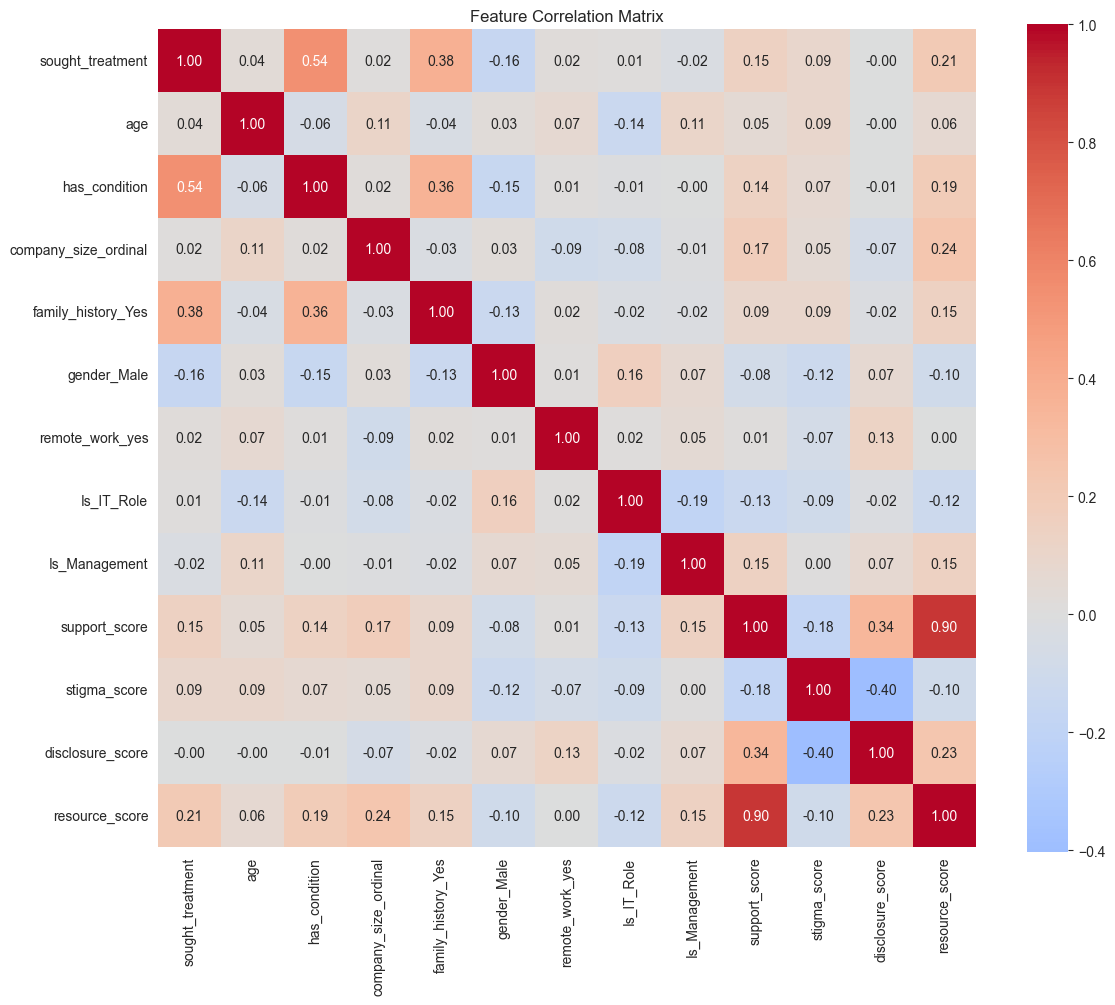


Highly correlated feature pairs (correlation > 0.8):
support_score - resource_score: 0.896
resource_score - support_score: 0.896


In [39]:
# Create correlation matrix
correlation_matrix = features_for_clustering.corr()

# Create heatmap visualization using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Show 2 decimal places
            square=True)  # Make cells square
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs (above 0.8 for example)
threshold = 0.8
high_corr = np.where(np.abs(correlation_matrix) > threshold)
high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x,y]) 
             for x, y in zip(*high_corr) if x != y]  # Exclude self-correlations

print("\nHighly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} - {feat2}: {corr:.3f}")

#### Start PCA analysis

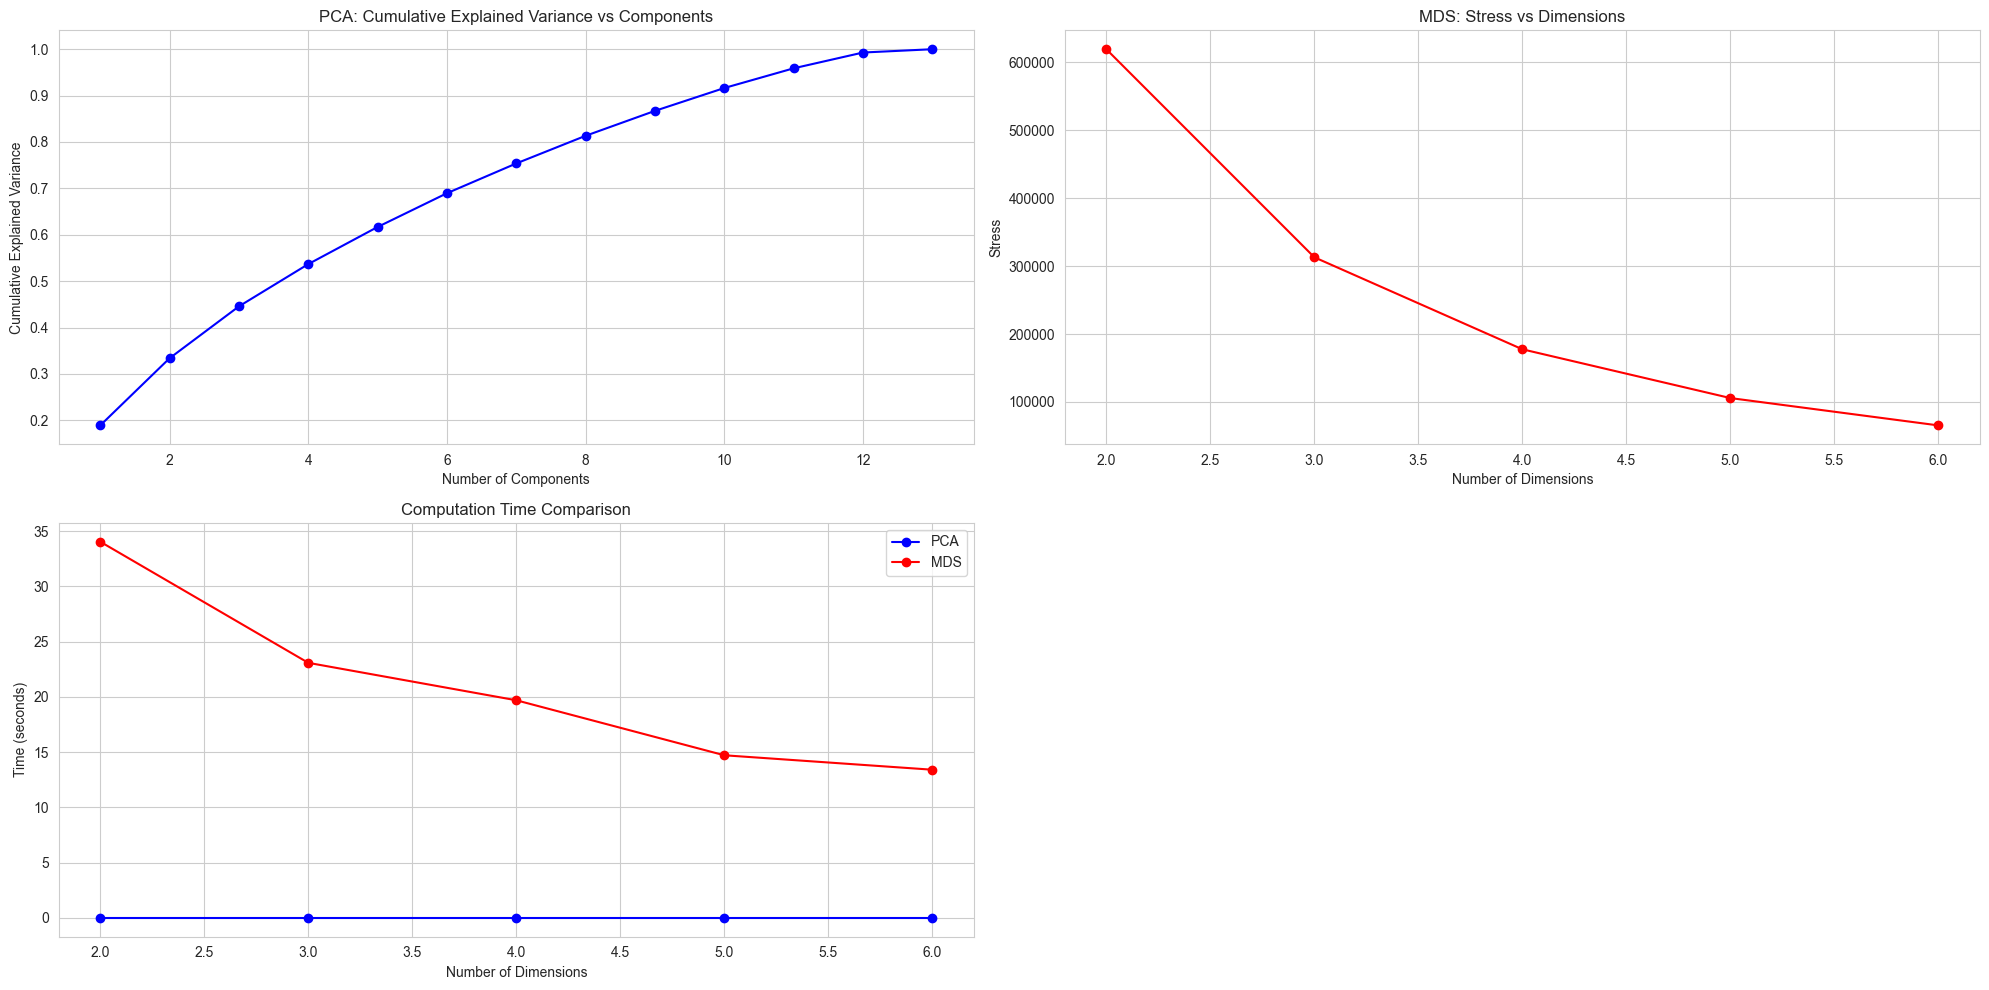


PCA Results:
Cumulative explained variance by dimensions:
1 dimensions: 0.189
2 dimensions: 0.334
3 dimensions: 0.446
4 dimensions: 0.537
5 dimensions: 0.617
6 dimensions: 0.690

MDS Results:
Stress values by dimensions:
2 dimensions: 619423.71
3 dimensions: 313015.11
4 dimensions: 177519.71
5 dimensions: 105675.99
6 dimensions: 65406.73

Computation Times (seconds):
Dimensions  PCA    MDS
         2  0.001 34.041
         3  0.001 23.082
         4  0.001 19.695
         5  0.001 14.718
         6  0.001 13.411


In [40]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_for_clustering)

# Set dimensions to try
n_dimensions = [2, 3, 4, 5, 6]

# PCA Analysis
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# MDS Analysis for different dimensions
mds_stress = []
mds_time = []
pca_time = []

for n_dim in n_dimensions:
    # PCA timing
    start_time = time.time()
    pca_n = PCA(n_components=n_dim)
    pca_n.fit_transform(data_scaled)
    pca_time.append(time.time() - start_time)
    
    # MDS timing and stress
    start_time = time.time()
    mds = MDS(n_components=n_dim, random_state=42)
    mds.fit_transform(data_scaled)
    mds_time.append(time.time() - start_time)
    mds_stress.append(mds.stress_)

# Plotting
plt.figure(figsize=(20, 10))

# Plot 1: PCA explained variance
plt.subplot(2, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs Components')
plt.grid(True)

# Plot 2: MDS Stress by dimensions
plt.subplot(2, 2, 2)
plt.plot(n_dimensions, mds_stress, 'ro-')
plt.xlabel('Number of Dimensions')
plt.ylabel('Stress')
plt.title('MDS: Stress vs Dimensions')
plt.grid(True)

# Plot 3: Computation Time Comparison
plt.subplot(2, 2, 3)
plt.plot(n_dimensions, pca_time, 'bo-', label='PCA')
plt.plot(n_dimensions, mds_time, 'ro-', label='MDS')
plt.xlabel('Number of Dimensions')
plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nPCA Results:")
print("Cumulative explained variance by dimensions:")
for i, var in enumerate(cumulative_variance[:6], 1):
    print(f"{i} dimensions: {var:.3f}")

print("\nMDS Results:")
print("Stress values by dimensions:")
for dim, stress in zip(n_dimensions, mds_stress):
    print(f"{dim} dimensions: {stress:.2f}")

print("\nComputation Times (seconds):")
print("Dimensions  PCA    MDS")
for dim, p_time, m_time in zip(n_dimensions, pca_time, mds_time):
    print(f"{dim:10d} {p_time:6.3f} {m_time:6.3f}")

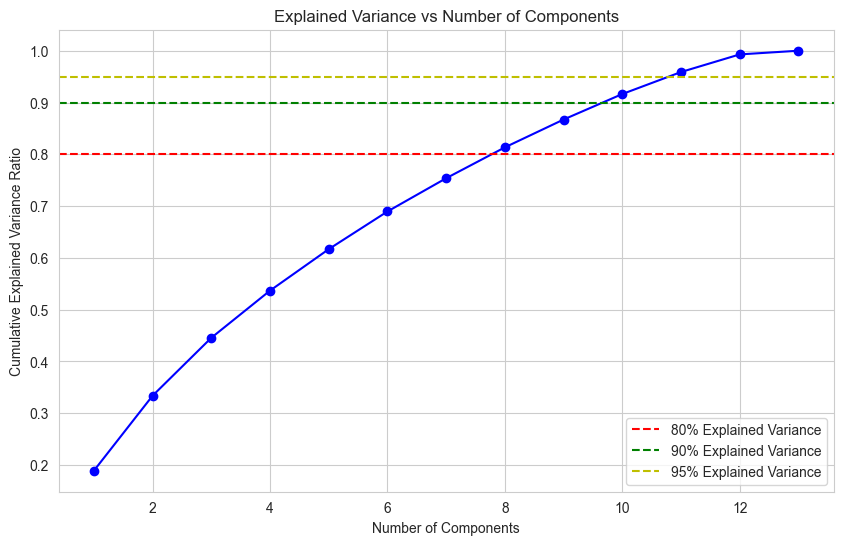


Number of components needed for:
80% variance: 8
90% variance: 10
95% variance: 11


In [41]:
# 4. Prepare data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

# 5. Determine optimal number of PCA components
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca_test = PCA(n_components=n_components)
pca_test.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
cumsum = np.cumsum(pca_test.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), cumsum, 'bo-')

# Add multiple threshold lines
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='y', linestyle='--', label='95% Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of components needed for each threshold
n_components_80 = np.argmax(cumsum >= 0.80) + 1
n_components_90 = np.argmax(cumsum >= 0.90) + 1
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\nNumber of components needed for:")
print(f"80% variance: {n_components_80}")
print(f"90% variance: {n_components_90}")
print(f"95% variance: {n_components_95}")

# 6. Apply PCA with chosen number of components (let's use 80% threshold as example)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

## Start Clustering

#### determine the optimal number of clusters using silhouette scores

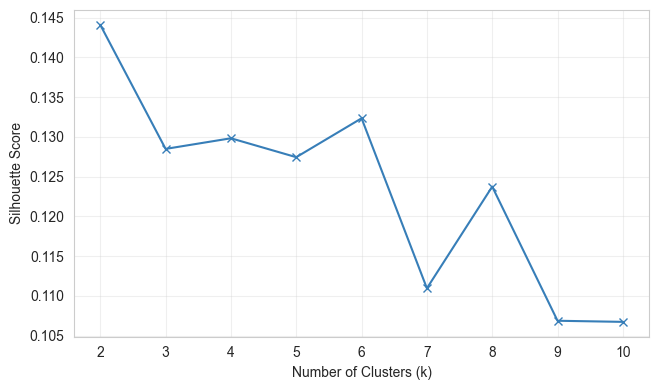

In [42]:
# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
   kmeans = KMeans(n_clusters=k, random_state=42)
   cluster_labels = kmeans.fit_predict(X_pca)
   silhouette_avg = silhouette_score(X_pca, cluster_labels)
   silhouette_scores.append(silhouette_avg)

# Create plot with A4 width dimensions
plt.figure(figsize=(6.69, 4))

# Plot silhouette scores with specific blue color
plt.plot(k_range, silhouette_scores, color='#377EB8', marker='x', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)  # Added alpha to match other plot

# Adjust layout
plt.tight_layout()
plt.show()

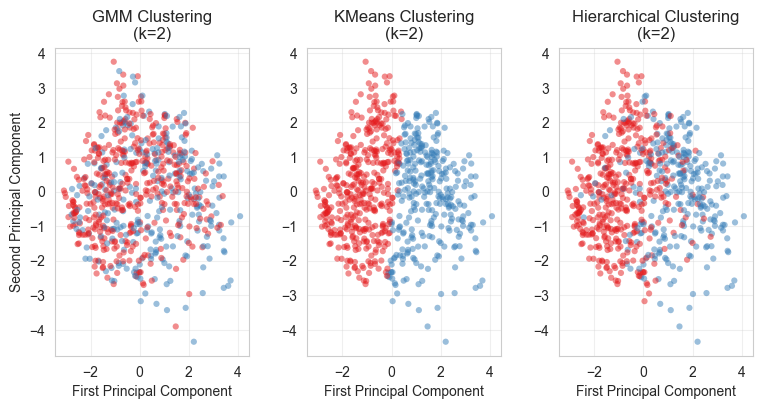


Comparison metrics for 2 clusters:

GMM:
Silhouette score: 0.117
Calinski-Harabasz score: 70.901
Davies-Bouldin score: 3.047
Cluster sizes: [437 267]

KMeans:
Silhouette score: 0.143
Calinski-Harabasz score: 120.723
Davies-Bouldin score: 2.350
Cluster sizes: [396 308]

Hierarchical:
Silhouette score: 0.110
Calinski-Harabasz score: 79.476
Davies-Bouldin score: 2.851
Cluster sizes: [430 274]


In [43]:
# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Create figure with A4 width dimensions
fig = plt.figure(figsize=(9, 4))
gs = fig.add_gridspec(1, 3, wspace=0.3)

n_fixed_clusters = 2
final_clusters = {}

# GMM
gmm = GaussianMixture(n_components=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['GMM'] = gmm.fit_predict(X_pca)

# K-means
kmeans = KMeans(n_clusters=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['KMeans'] = kmeans.fit_predict(X_pca)

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=n_fixed_clusters)
final_clusters['Hierarchical'] = hierarchical.fit_predict(X_pca)

# Define high contrast colors
colors = ['#E41A1C', '#377EB8']  # Red and Blue

# Plot clustering results with improved visuals
for i, (method, labels) in enumerate(final_clusters.items()):
   ax = fig.add_subplot(gs[0, i])
   scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=[colors[l] for l in labels],
                       alpha=0.5,
                       s=20,
                       linewidth=0)
   ax.set_title(f'{method} Clustering\n(k={n_fixed_clusters})')
   ax.set_xlabel('First Principal Component')
   ax.set_ylabel('Second Principal Component' if i == 0 else '')
   ax.grid(True, alpha=0.3)

plt.show()

# Print comparison metrics
print("\nComparison metrics for 2 clusters:")  # Updated to reflect k=2
for method, labels in final_clusters.items():
   print(f"\n{method}:")
   try:
       silhouette_avg = silhouette_score(X_pca, labels)
       calinski = calinski_harabasz_score(X_pca, labels)
       davies = davies_bouldin_score(X_pca, labels)
       
       print(f"Silhouette score: {silhouette_avg:.3f}")
       print(f"Calinski-Harabasz score: {calinski:.3f}")
       print(f"Davies-Bouldin score: {davies:.3f}")
       print(f"Cluster sizes: {np.bincount(labels)}")
   
   except ValueError as e:
       print(f"Error calculating scores: {e}")

## Results

In [44]:
fullfeature_df.head()
fullfeature_df.to_csv()

',tech_company,sought_treatment,age,has_condition,company_size_ordinal,emp_mh_benefits_Yes,emp_mh_benefits_I_dont_know,emp_mh_benefits_No,know_mh_options_Yes,know_mh_options_No,emp_discussed_mh_Yes,emp_discussed_mh_No,emp_discussed_mh_I_don_t_know,anonymity_protected_Yes,anonymity_protected_No,anonymity_protected_I_don_t_know,mh_resources_Yes,mh_resources_No,mh_resources_I_don_t_know,leave_difficulty_Somewhat_easy,leave_difficulty_Neither_easy_nor_difficult,leave_difficulty_Very_easy,leave_difficulty_Very_difficult,leave_difficulty_Somewhat_difficult,leave_difficulty_I_don_t_know,neg_consequences_mental_discuss_No,neg_consequences_mental_discuss_Yes,neg_consequences_mental_discuss_Maybe,comfortable_discuss_coworkers_Maybe,comfortable_discuss_coworkers_Yes,comfortable_discuss_coworkers_No,comfortable_discuss_supervisors_Yes,comfortable_discuss_supervisors_No,comfortable_discuss_supervisors_Maybe,emp_mh_seriously_Yes,emp_mh_seriously_No,emp_mh_seriously_I_don_t_know,observed_neg_conseque

In [45]:
# Copy data and add cluster labels
df = fullfeature_df.copy()
df['Cluster'] = final_clusters['KMeans']

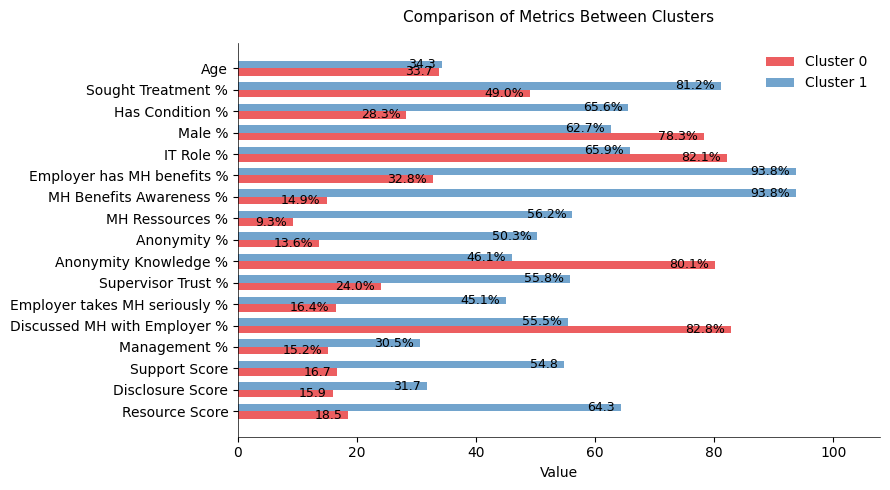

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Set style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.style.use('default')  # Reset to default style with white background

# Analyze first cluster
cluster_0 = df[df['Cluster'] == 0]
cluster_0_metrics = {
    'Size': len(cluster_0),
    'Age': f"{cluster_0['age'].mean():.1f}",
    'Sought Treatment %': f"{cluster_0['sought_treatment'].mean()*100:.1f}%",
    'Has Condition %': f"{cluster_0['has_condition'].mean()*100:.1f}%",
    'Male %': f"{cluster_0['gender_Male'].mean()*100:.1f}%",
    'IT Role %': f"{cluster_0['Is_IT_Role'].mean()*100:.1f}%",
    'Employer has MH benefits %': f"{cluster_0['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Benefits Awareness %': f"{cluster_0['know_mh_options_Yes'].mean()*100:.1f}%",
    'MH Ressources %': f"{cluster_0['mh_resources_Yes'].mean()*100:.1f}%",
    'Anonymity %': f"{cluster_0['anonymity_protected_Yes'].mean()*100:.1f}%",
    'Anonymity Knowledge %': f"{cluster_0['anonymity_protected_I_don_t_know'].mean()*100:.1f}%",
    'Supervisor Trust %': f"{cluster_0['comfortable_discuss_supervisors_Yes'].mean()*100:.1f}%",
    'Employer takes MH seriously %': f"{cluster_0['emp_mh_seriously_Yes'].mean()*100:.1f}%",
    'Discussed MH with Employer %': f"{cluster_0['emp_discussed_mh_No'].mean()*100:.1f}%",
    'Management %': f"{cluster_0['Is_Management'].mean()*100:.1f}%",
    'Support Score': f"{cluster_0['support_score'].mean():.1f}",
    'Disclosure Score': f"{cluster_0['disclosure_score'].mean():.1f}",
    'Resource Score': f"{cluster_0['resource_score'].mean():.1f}"
}

# Analyze second cluster
cluster_1 = df[df['Cluster'] == 1]
cluster_1_metrics = {
    'Size': len(cluster_1),
    'Age': f"{cluster_1['age'].mean():.1f}",
    'Sought Treatment %': f"{cluster_1['sought_treatment'].mean()*100:.1f}%",
    'Has Condition %': f"{cluster_1['has_condition'].mean()*100:.1f}%",
    'Male %': f"{cluster_1['gender_Male'].mean()*100:.1f}%",
    'IT Role %': f"{cluster_1['Is_IT_Role'].mean()*100:.1f}%",
    'Employer has MH benefits %': f"{cluster_1['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Benefits Awareness %': f"{cluster_1['emp_mh_benefits_Yes'].mean()*100:.1f}%",
    'MH Ressources %': f"{cluster_1['mh_resources_Yes'].mean()*100:.1f}%",
    'Anonymity %': f"{cluster_1['anonymity_protected_Yes'].mean()*100:.1f}%",
    'Anonymity Knowledge %': f"{cluster_1['anonymity_protected_I_don_t_know'].mean()*100:.1f}%",
    'Supervisor Trust %': f"{cluster_1['comfortable_discuss_supervisors_Yes'].mean()*100:.1f}%",
    'Employer takes MH seriously %': f"{cluster_1['emp_mh_seriously_Yes'].mean()*100:.1f}%",
    'Discussed MH with Employer %': f"{cluster_1['emp_discussed_mh_No'].mean()*100:.1f}%",
    'Management %': f"{cluster_1['Is_Management'].mean()*100:.1f}%",
    'Support Score': f"{cluster_1['support_score'].mean():.1f}",
    'Disclosure Score': f"{cluster_1['disclosure_score'].mean():.1f}",
    'Resource Score': f"{cluster_1['resource_score'].mean():.1f}"
}

# Remove 'Size' and convert other metrics to numeric values
plot_metrics = {k: float(v.rstrip('%')) if isinstance(v, str) and '%' in v else float(v) 
                for k, v in cluster_0_metrics.items() 
                if k != 'Size'}

# Create lists of metrics and values
metrics = list(plot_metrics.keys())
cluster0_values = [float(cluster_0_metrics[m].rstrip('%')) if isinstance(cluster_0_metrics[m], str) and '%' in cluster_0_metrics[m] 
                   else float(cluster_0_metrics[m]) for m in metrics]
cluster1_values = [float(cluster_1_metrics[m].rstrip('%')) if isinstance(cluster_1_metrics[m], str) and '%' in cluster_1_metrics[m] 
                   else float(cluster_1_metrics[m]) for m in metrics]

# Create figure with dimensions proportional to A4
fig = plt.figure(figsize=(9, 5), facecolor='white')
ax = fig.add_subplot(111)
ax.set_facecolor('white')  # Explicitly set axes background to white

# Define bar positions
y_pos = np.arange(len(metrics))
bar_height = 0.35

# Create bars with specified colors
cluster0_bars = ax.barh(y_pos + bar_height/2, cluster0_values, bar_height, 
                       label='Cluster 0', color='#E41A1C', alpha=0.7, edgecolor='none')
cluster1_bars = ax.barh(y_pos - bar_height/2, cluster1_values, bar_height, 
                       label='Cluster 1', color='#377EB8', alpha=0.7, edgecolor='none')

# Add data labels to each bar
def add_labels(bars, values, metrics_list):
    for bar, value, metric in zip(bars, values, metrics_list):
        width = bar.get_width()
        
        # Format value labels based on the metric type
        if metric == 'Age':
            # For Age, show as years without % symbol
            label_text = f"{value:.1f}"
        elif '%' in metric:
            # For percentage metrics, add % symbol
            label_text = f"{value:.1f}%"
        else:
            # For score metrics, just show the value
            label_text = f"{value:.1f}"
        
        # Position labels at the end of each bar with small padding
        # If the bar is short, place the label outside the bar
        if width < max(cluster0_values + cluster1_values) * 0.05:
            x_pos = width + 1
            ha = 'left'
        else:
            x_pos = width - 1
            ha = 'right'
            
        ax.text(x_pos, 
                bar.get_y() + bar.get_height()/2, 
                label_text, 
                va='center', 
                ha=ha,
                fontsize=9,
                fontweight='normal',
                color='black')  # Ensure text is black for visibility

# Add labels to both sets of bars
add_labels(cluster0_bars, cluster0_values, metrics)
add_labels(cluster1_bars, cluster1_values, metrics)

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(metrics)
ax.invert_yaxis()  # Reverse order to have first metric at top

# Turn off all grid lines
ax.grid(False)

# Remove top and right spines to match the clean style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add labels and title with styling
ax.set_xlabel('Value', fontsize=10)
ax.set_title('Comparison of Metrics Between Clusters', fontsize=11, pad=15)

# Add legend with styling to match reference
legend = ax.legend(frameon=False)

# Ensure axes limits include space for labels
max_value = max(cluster0_values + cluster1_values)
ax.set_xlim(0, max_value * 1.15)  # Add 15% margin for labels

# Adjust layout
plt.tight_layout()

# Show plot with clean white background
plt.show()

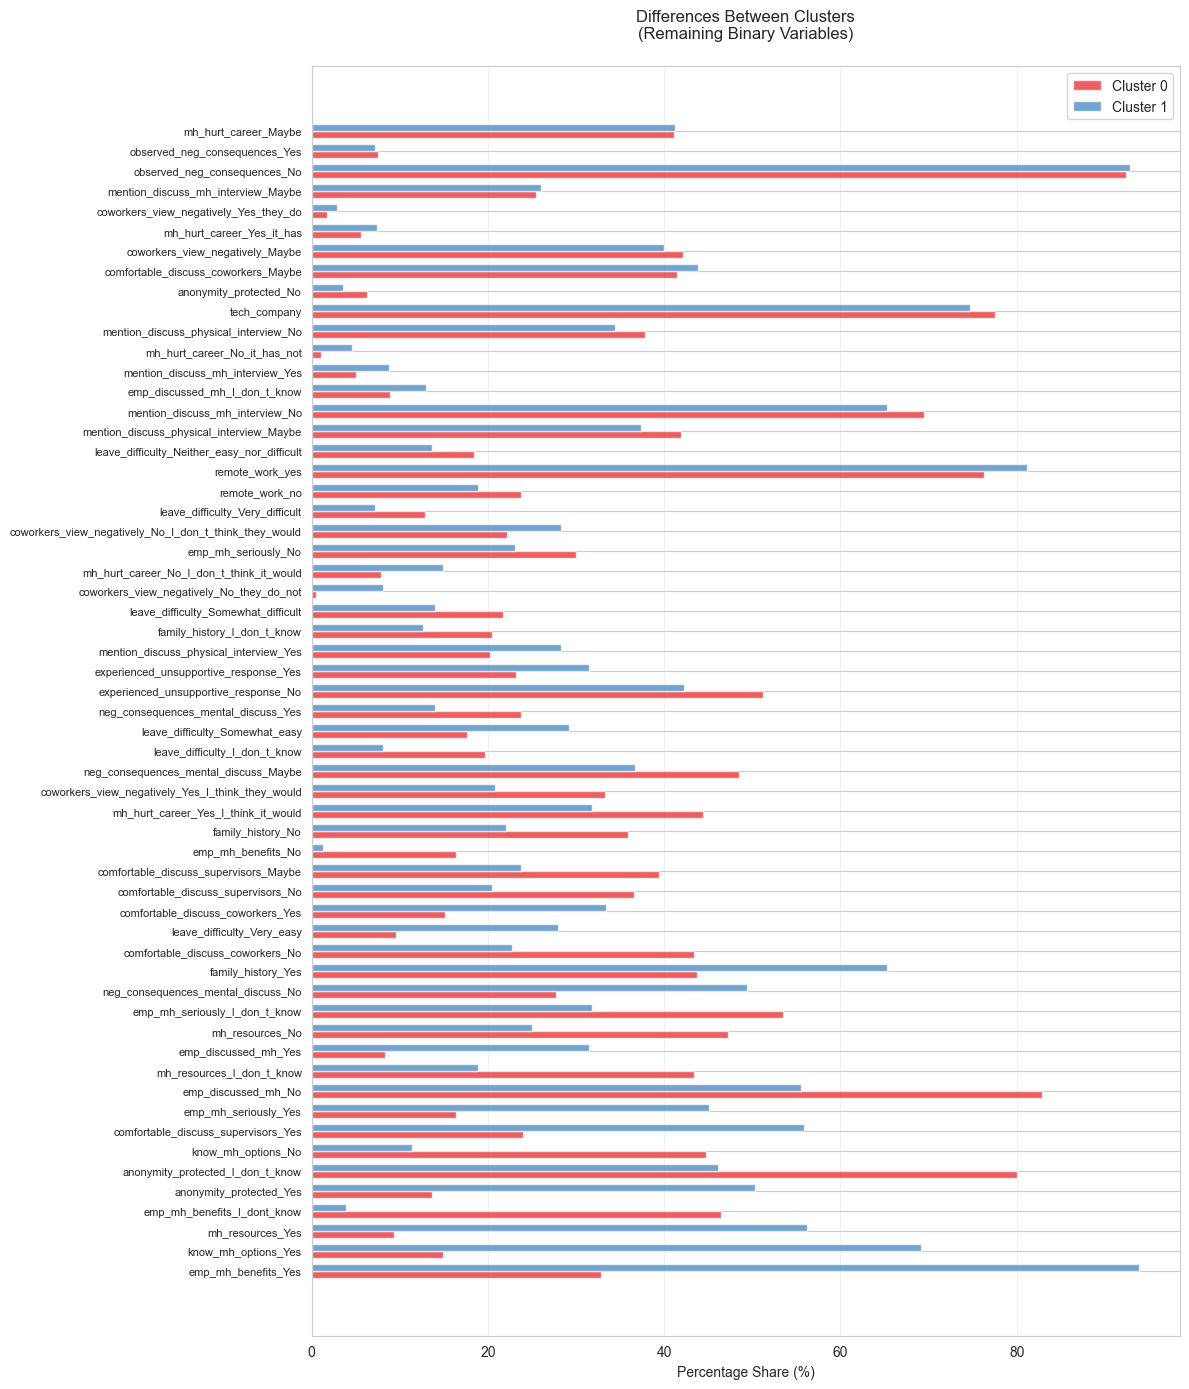


Top binary feature differences between clusters:

emp_mh_benefits_Yes:
  Cluster 0: 32.8%
  Cluster 1: 93.8%
  Absolute Difference: 61.0%

know_mh_options_Yes:
  Cluster 0: 14.9%
  Cluster 1: 69.2%
  Absolute Difference: 54.3%

mh_resources_Yes:
  Cluster 0: 9.3%
  Cluster 1: 56.2%
  Absolute Difference: 46.8%

emp_mh_benefits_I_dont_know:
  Cluster 0: 46.5%
  Cluster 1: 3.9%
  Absolute Difference: 42.6%

anonymity_protected_Yes:
  Cluster 0: 13.6%
  Cluster 1: 50.3%
  Absolute Difference: 36.7%

anonymity_protected_I_don_t_know:
  Cluster 0: 80.1%
  Cluster 1: 46.1%
  Absolute Difference: 33.9%

know_mh_options_No:
  Cluster 0: 44.7%
  Cluster 1: 11.4%
  Absolute Difference: 33.3%

comfortable_discuss_supervisors_Yes:
  Cluster 0: 24.0%
  Cluster 1: 55.8%
  Absolute Difference: 31.9%

emp_mh_seriously_Yes:
  Cluster 0: 16.4%
  Cluster 1: 45.1%
  Absolute Difference: 28.7%

emp_discussed_mh_No:
  Cluster 0: 82.8%
  Cluster 1: 55.5%
  Absolute Difference: 27.3%


In [47]:
# Define columns to exclude (already analyzed)
exclude_columns = ['age', 'Cluster', 'support_score', 'stigma_score', 
                  'disclosure_score', 'resource_score', 'sought_treatment',
                  'has_condition', 'gender_Male', 'gender_Female', 
                  'Is_IT_Role', 'Is_Management', 'company_size_ordinal']

# Calculate means for binary columns
cluster0_means = (cluster_0.mean() * 100)
cluster1_means = (cluster_1.mean() * 100)

# Create differences DataFrame
differences = pd.DataFrame({
    'Cluster0': cluster0_means,
    'Cluster1': cluster1_means,
    'AbsDiff': abs(cluster0_means - cluster1_means)
})

# Drop excluded columns and non-binary columns
differences_cleaned = differences.drop(exclude_columns, errors='ignore')

# Sort by absolute difference
differences_sorted = differences_cleaned.sort_values('AbsDiff', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 14))

y_pos = np.arange(len(differences_sorted.index))
bar_height = 0.35

# Create bars
ax.barh(y_pos + bar_height/2, differences_sorted['Cluster0'], bar_height, 
        label='Cluster 0', color='#E41A1C', alpha=0.7)
ax.barh(y_pos - bar_height/2, differences_sorted['Cluster1'], bar_height, 
        label='Cluster 1', color='#377EB8', alpha=0.7)

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(differences_sorted.index, fontsize=8)
ax.invert_yaxis()

# Add grid
ax.grid(True, axis='x', alpha=0.3)

# Add labels and title
ax.set_xlabel('Percentage Share (%)')
ax.set_title('Differences Between Clusters\n(Remaining Binary Variables)', pad=20)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print top differences
print("\nTop binary feature differences between clusters:")
differences_sorted_desc = differences_sorted.sort_values('AbsDiff', ascending=False)
for col in differences_sorted_desc.head(10).index:
    print(f"\n{col}:")
    print(f"  Cluster 0: {differences_sorted_desc.loc[col, 'Cluster0']:.1f}%")
    print(f"  Cluster 1: {differences_sorted_desc.loc[col, 'Cluster1']:.1f}%")
    print(f"  Absolute Difference: {differences_sorted_desc.loc[col, 'AbsDiff']:.1f}%")

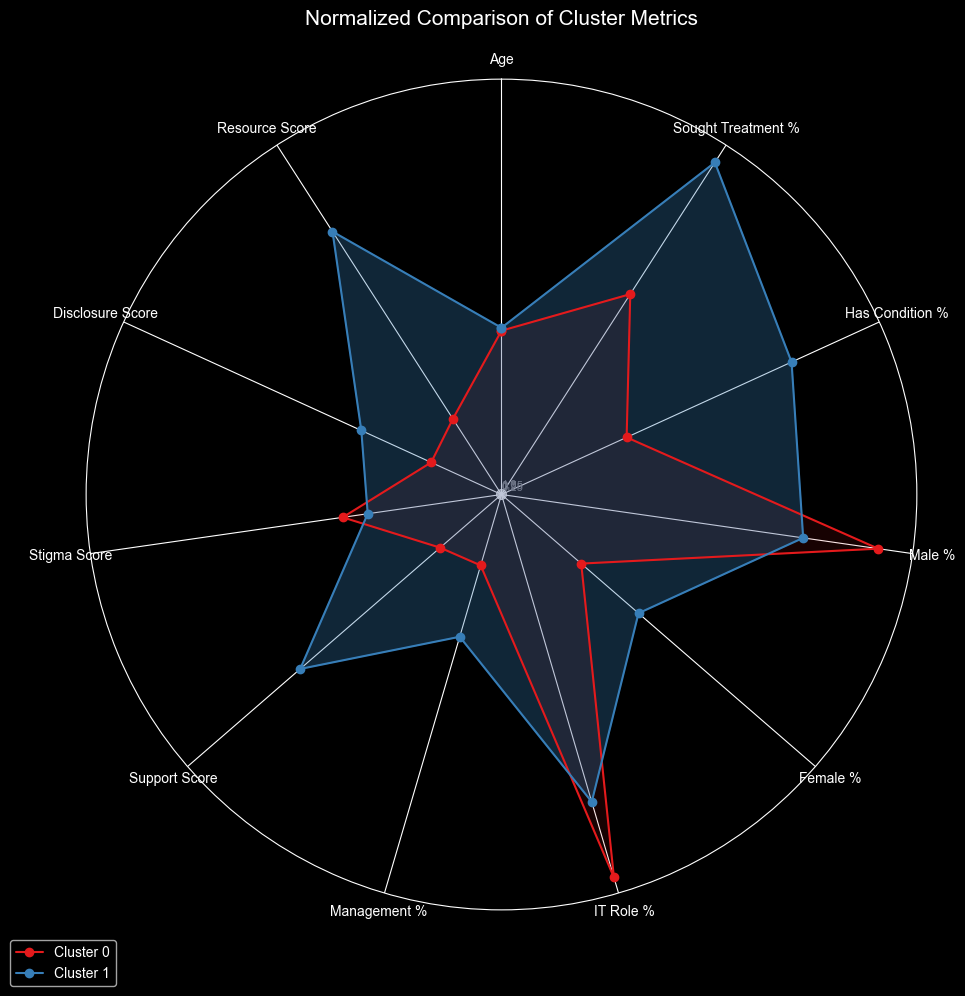